In [7]:
import sys
sys.path.append("..")

import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from utils.utils import getHashFromDict, readContentFromFile
from concurrent.futures import ProcessPoolExecutor

In [8]:
EXPERIMENTS_BASE_PATH = "./experiments/noisyTransferLearning"

In [9]:
experimentsResults = []
for path in tqdm(glob(f"{crossValidationExperimentsPath}/*")):
    experimentId = os.path.basename(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{crossValidationExperimentsPath}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{crossValidationExperimentsPath}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)

targetDatabaseDF = experimentsResultsDF["targetDatabase"].apply(pd.Series)
targetDatabaseDF.columns = ["targetDomain", "target_targetPredicate", "target_resetTargetPredicate"]
targetDatabaseDF["targetDomain"] = targetDatabaseDF.targetDomain.apply(lambda databasePath: os.path.basename(databasePath))
sourceDatabaseDF = experimentsResultsDF["sourceDatabase"].apply(pd.Series)
sourceDatabaseDF.columns = ["sourceDomain", "source_targetPredicate", "source_resetTargetPredicate"]
sourceDatabaseDF["sourceDomain"] = sourceDatabaseDF.sourceDomain.apply(lambda databasePath: os.path.basename(databasePath))
metricsDF = experimentsResultsDF["metrics"].apply(pd.Series)
metricsDF.columns = ["metrics_transferLearning", "metrics_originalRDNBoost", "metrics_analogousToOriginalRDNBoost"]

experimentsResultsDF = pd.concat([experimentsResultsDF, targetDatabaseDF, sourceDatabaseDF, metricsDF], axis = 1)
experimentsResultsDF = experimentsResultsDF.drop(["targetDatabase", "sourceDatabase", "metrics", "ignoreSTDOUT"], axis = 1)

# experimentsResultsDF["target_targetPredicate"] = experimentsResultsDF.apply(
#     lambda row: re.findall(
#         r"targetPred:\s+(\w.*)/\d+", 
#         readContentFromFile(glob(f"{row.path}/{row.id}/**/train_output.txt", recursive = True)[0])
#     )[0], 
#     axis = 1
# )

print("Total experiments:", experimentsResultsDF.shape[0])

NameError: name 'crossValidationExperimentsPath' is not defined

# **Cross Validation**

In [ ]:
crossValidationExperimentsPath = f"{EXPERIMENTS_BASE_PATH}/crossValidation"

In [ ]:
def calculateUtility(experimentId, targetUtilityAlphaList):
    foldPredictionPathList = glob(f"{crossValidationExperimentsPath}/{experimentId}/**/aucTemp.txt", recursive = True)
    utilities = []
    for predictionPath in foldPredictionPathList:
        fold = re.findall(r".*(fold[0-9]+).*", predictionPath)[0]
        foldUtilities = []
        for targetUtilityAlpha in targetUtilityAlphaList:
            oneMinusTargetUtilityAlpha = 1 - targetUtilityAlpha
            foldPredictions = readContentFromFile(predictionPath).strip()
            foldPredictions = pd.DataFrame([
                [float(value) for value in instance.split(" ")] for instance in foldPredictions.split("\n")
            ], columns = ["prob", "label"])
            foldPredictions["label"] = foldPredictions.label.astype(int)
            foldPredictions["pmf"] = foldPredictions.apply(lambda row: row.prob if row.label == 1 else (1-row.prob), axis = 1)
            foldPredictions["alphaFairness"] = foldPredictions.pmf.apply(lambda z: np.log(z) if targetUtilityAlpha == 1 else np.power(z,oneMinusTargetUtilityAlpha)/oneMinusTargetUtilityAlpha)
            foldUtility = foldPredictions.alphaFairness.mean()
            foldUtilities.append(foldUtility)
        utilities.append([experimentId, fold, *foldUtilities])
    return pd.DataFrame(data = utilities, columns = ["experimentID", "fold", *[f"utility@targetAlpha_{alpha}" for alpha in targetUtilityAlphaList]])

In [ ]:
experimentsResults = []
for path in tqdm(glob(f"{crossValidationExperimentsPath}/*")):
    experimentId = os.path.basename(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{crossValidationExperimentsPath}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{crossValidationExperimentsPath}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)

targetDatabaseDF = experimentsResultsDF["targetDatabase"].apply(pd.Series)
targetDatabaseDF.columns = ["targetDomain", "target_targetPredicate", "target_resetTargetPredicate"]
targetDatabaseDF["targetDomain"] = targetDatabaseDF.targetDomain.apply(lambda databasePath: os.path.basename(databasePath))
sourceDatabaseDF = experimentsResultsDF["sourceDatabase"].apply(pd.Series)
sourceDatabaseDF.columns = ["sourceDomain", "source_targetPredicate", "source_resetTargetPredicate"]
sourceDatabaseDF["sourceDomain"] = sourceDatabaseDF.sourceDomain.apply(lambda databasePath: os.path.basename(databasePath))
metricsDF = experimentsResultsDF["metrics"].apply(pd.Series)
metricsDF.columns = ["metrics_transferLearning", "metrics_originalRDNBoost", "metrics_analogousToOriginalRDNBoost"]

experimentsResultsDF = pd.concat([experimentsResultsDF, targetDatabaseDF, sourceDatabaseDF, metricsDF], axis = 1)
experimentsResultsDF = experimentsResultsDF.drop(["targetDatabase", "sourceDatabase", "metrics", "ignoreSTDOUT"], axis = 1)

# experimentsResultsDF["target_targetPredicate"] = experimentsResultsDF.apply(
#     lambda row: re.findall(
#         r"targetPred:\s+(\w.*)/\d+", 
#         readContentFromFile(glob(f"{row.path}/{row.id}/**/train_output.txt", recursive = True)[0])
#     )[0], 
#     axis = 1
# )

print("Total experiments:", experimentsResultsDF.shape[0])

100%|██████████| 3516/3516 [13:47<00:00,  4.25it/s]


Total experiments: 3516


In [ ]:
experimentIdList = experimentsResultsDF.id.unique().tolist()
with ProcessPoolExecutor(max_workers = 10) as p:
    results = list(
        tqdm(
            p.map(calculateUtility, experimentIdList, [(0.0,0.3,0.6,1.0,1.3) for i in experimentIdList]), 
            total=len(experimentIdList)
        )
    )

experimentsUtilitiesDF = pd.concat(results, axis = 0).reset_index(drop = True)
print(experimentsUtilitiesDF.shape)
experimentsUtilitiesDF.head()

100%|██████████| 3516/3516 [53:35<00:00,  1.09it/s]  


(13564, 7)


,experimentID,fold,utility@targetAlpha_0.0,utility@targetAlpha_0.3,utility@targetAlpha_0.6,utility@targetAlpha_1.0,utility@targetAlpha_1.3
0,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,fold00,0.854949,1.277948,2.343022,-0.167207,-3.510198
1,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,fold01,0.855988,1.276594,2.338048,-0.180192,-3.533254
2,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,fold02,0.863985,1.286630,2.350993,-0.161034,-3.506343
3,00211469e7d68242b8a5fd2170a8001164382df617e84d...,fold00,0.823702,1.242530,2.302601,-0.215951,-3.566741
4,00211469e7d68242b8a5fd2170a8001164382df617e84d...,fold01,0.862913,1.282483,2.342529,-0.178223,-3.533526


In [ ]:
experimentsResultsDF.groupby(["sourceDomain", "targetDomain"])[["id"]].count()

id
sourceDomain  targetDomain      
cora          imdb           502
imdb          cora           502
              uwcse          502
nell_finances nell_sports    502
nell_sports   nell_finances  502
twitter       yeast          502
uwcse         imdb             2
yeast         twitter        502

# **Original RDN-Boost**

In [ ]:
def filterOriginalRDNBoostResultsDF(
    targetDomain = None, 
    target_targetPredicate = None,
):
    df = originalRDNBoostDF.copy()

    if targetDomain:
        df = df[df.targetDomain == targetDomain]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    return df

In [ ]:
originalRDNBoostDF = experimentsResultsDF[experimentsResultsDF["runOriginalRDNBoost"] == True].copy(deep = True)

originalRDNBoostMetricsDF = originalRDNBoostDF[["id", "metrics_originalRDNBoost"]].copy()
originalRDNBoostMetricsDF.columns = ["experimentID", "metrics"]
originalRDNBoostMetricsDF["metrics"] = originalRDNBoostMetricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.explode("metrics")
originalRDNBoostMetricsDF["fold"] = originalRDNBoostMetricsDF.metrics.apply(lambda metrics: metrics[0])
originalRDNBoostMetricsDF["metrics"] = originalRDNBoostMetricsDF.metrics.apply(lambda metrics: metrics[1])
originalRDNBoostMetricsDF = pd.concat(
    [originalRDNBoostMetricsDF, originalRDNBoostMetricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.drop(["metrics"], axis = 1)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.sort_values("experimentID")
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.reset_index(drop = True)
originalRDNBoostMetricsDF = pd.merge(
    originalRDNBoostMetricsDF, 
    experimentsUtilitiesDF, 
    on = ["experimentID", "fold"], 
    how = "left"
)

columnsToKeep = [
    'id', 'targetDomain', 'target_targetPredicate', 'useRecursion', 'path', 'negPosRatio', 'randomSeed', 
    'maxFailedNegSamplingRetries', 'numberOfClauses', 'numberOfCycles', 'maxTreeDepth', 'nEstimators', 'nodeSize'
]
originalRDNBoostDF = originalRDNBoostDF[columnsToKeep].copy(deep = True)

originalRDNBoostDF["aucROC_mean"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.mean()
)
originalRDNBoostDF["aucROC_std"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.std()
)
originalRDNBoostDF["aucPR_mean"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.mean()
)
originalRDNBoostDF["aucPR_std"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.std()
)

In [ ]:
originalRDNBoostDF

,id,targetDomain,target_targetPredicate,useRecursion,path,negPosRatio,randomSeed,maxFailedNegSamplingRetries,numberOfClauses,numberOfCycles,maxTreeDepth,nEstimators,nodeSize,aucROC_mean,aucROC_std,aucPR_mean,aucPR_std
93,0726cac0b41d9aa866dbf57bd36b115ed1c50e11afedc0...,nell_sports,None,True,./experiments/crossValidation,2,11,50,8,100,3,10,2,0.989048,0.006170,0.965925,0.026593
1124,51d101f2e9cfac1aa4edb1f463accf3f6b5d41f573f52a...,imdb,None,False,./experiments/crossValidation,2,11,50,8,100,3,10,2,1.000000,0.000000,1.000000,0.000000
1451,6a38ecd1ee6f57493bdc4d5565d196340eefe7466041f7...,imdb,None,False,./experiments/crossValidation,2,11,50,8,100,3,10,2,1.000000,0.000000,1.000000,0.000000
1457,6a9f022b5fc34609ec98a9898cafb1845f9e40acb61a13...,yeast,None,True,./experiments/crossValidation,2,11,50,8,100,3,10,2,0.867002,0.088602,0.811415,0.109036
1778,816f88e322ad9332974b410b99743c591cfb2829177084...,cora,None,False,./experiments/crossValidation,2,11,50,8,100,3,10,2,0.646198,0.146544,0.473191,0.151364
2542,b66e86ba8b85a4ad471123e9d4010515430a0c49c6fa23...,twitter,None,True,./experiments/crossValidation,2,11,50,8,100,3,10,2,0.993062,0.003844,0.982757,0.011079
2641,bf61e2b7f32e7599b7a4c2e147a01836132f2ca951dcf0...,nell_finances,None,True,./experiments/crossValidation,2,11,50,8,100,3,10,2,0.718829,0.051323,0.628930,0.070847
2661,c0b61053859b77b0901fecdeaad7db8405a209cd76add3...,uwcse,None,False,./experiments/crossValidation,2,11,50,8,100,3,10,2,0.921652,0.040539,0.783410,0.097891


# **Instance-based Transfer Learning (Our Approach)**

In [ ]:
transferLearningDF = experimentsResultsDF[experimentsResultsDF["runTransferLearning"] == True].copy(deep = True)
transferLearningDF["mappingID"] = transferLearningDF.mapping.apply(lambda mapping: getHashFromDict(mapping))
transferLearningDF["weightID"] = transferLearningDF.weight.apply(lambda weight: getHashFromDict(weight))

transferLearningMappingsDF = transferLearningDF["mapping"].apply(pd.Series)
transferLearningMappingsDF = pd.concat([transferLearningDF[["mappingID"]], transferLearningMappingsDF], axis = 1)
transferLearningMappingsDF = transferLearningMappingsDF.drop_duplicates(subset = ["mappingID"])
transferLearningMappingsDF = transferLearningMappingsDF.reset_index(drop = True)
transferLearningMappingsDF["mappingShortID"] = [f"M{id+1:03d}" for id in transferLearningMappingsDF.index]
# NOTE: the mappingShortID may change when new experiments are carried out. Always be sure that the plots related to mappings are updated.

transferLearningWeightDF = transferLearningDF["weight"].apply(pd.Series)
transferLearningWeightDF = pd.concat([transferLearningDF[["weightID"]], transferLearningWeightDF], axis = 1)
transferLearningWeightDF = transferLearningWeightDF.drop_duplicates(subset = ["weightID"])
transferLearningWeightDF = transferLearningWeightDF.reset_index(drop = True)
transferLearningWeightDF["weightShortID"] = [f"W{id+1:03d}" for id in transferLearningWeightDF.index]
# NOTE: the mappingShortID may change when new experiments are carried out. Always be sure that the plots related to mappings are updated.

transferLearningMetricsDF = transferLearningDF[["id", "metrics_transferLearning"]].copy()
transferLearningMetricsDF.columns = ["experimentID", "metrics"]
transferLearningMetricsDF["metrics"] = transferLearningMetricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
transferLearningMetricsDF = transferLearningMetricsDF.explode("metrics")
transferLearningMetricsDF["fold"] = transferLearningMetricsDF.metrics.apply(lambda metrics: metrics[0])
transferLearningMetricsDF["metrics"] = transferLearningMetricsDF.metrics.apply(lambda metrics: metrics[1])
transferLearningMetricsDF = pd.concat(
    [transferLearningMetricsDF, transferLearningMetricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
transferLearningMetricsDF = transferLearningMetricsDF.drop(["metrics"], axis = 1)
transferLearningMetricsDF = transferLearningMetricsDF.sort_values("experimentID")
transferLearningMetricsDF = transferLearningMetricsDF.reset_index(drop = True)
transferLearningMetricsDF = pd.merge(
    transferLearningMetricsDF, 
    experimentsUtilitiesDF, 
    on = ["experimentID", "fold"], 
    how = "left"
)

columnsToKeep = [
    'id', 'sourceDomain', 'targetDomain', 'target_targetPredicate', 'sourceUtilityAlpha', 'targetUtilityAlpha',  
    'utilityAlphaSetIter', 'mappingID', 'weightID', 'useRecursion', 'path', 'negPosRatio', 'randomSeed', 
    'maxFailedNegSamplingRetries', 'numberOfClauses', 'numberOfCycles', 'maxTreeDepth', 'nEstimators', 'nodeSize'
]
transferLearningDF = transferLearningDF[columnsToKeep].copy(deep = True)

transferLearningDF = pd.merge(
    transferLearningDF, 
    transferLearningMappingsDF[["mappingID", "mappingShortID"]], 
    on = "mappingID", 
    how = "left"
)

transferLearningDF = pd.merge(
    transferLearningDF, 
    transferLearningWeightDF[["weightID", "weightShortID"]], 
    on = "weightID", 
    how = "left"
)

transferLearningDF["aucROC_mean"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucROC.mean()
)
transferLearningDF["aucROC_std"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucROC.std()
)
transferLearningDF["aucPR_mean"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucPR.mean()
)
transferLearningDF["aucPR_std"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucPR.std()
)

In [ ]:
print(transferLearningDF.shape)
transferLearningDF.head(3)

(3500, 25)


,id,sourceDomain,targetDomain,target_targetPredicate,sourceUtilityAlpha,targetUtilityAlpha,utilityAlphaSetIter,mappingID,weightID,useRecursion,...,numberOfCycles,maxTreeDepth,nEstimators,nodeSize,mappingShortID,weightShortID,aucROC_mean,aucROC_std,aucPR_mean,aucPR_std
0,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,nell_finances,nell_sports,None,0.3,1.0,3.0,77d1b001c655f10d6af95f3425c9f67c79008674133a3b...,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,True,...,100,3,10,2,M001,W001,0.991085,0.005759,0.977933,0.020142
1,00211469e7d68242b8a5fd2170a8001164382df617e84d...,yeast,twitter,None,1.3,0.0,5.0,afe4407960a1617c8a6b385a75d1aeb5c73f3e177c95fe...,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,True,...,100,3,10,2,M002,W001,0.992087,0.002684,0.976052,0.014832
2,00479b54d3e9c1a180fbdc3ee8a06a209072013989ed7b...,imdb,uwcse,None,1.0,1.0,3.0,1ffdbc8a031887b5269deb3e32673c646b3a72c585e7e0...,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,False,...,100,3,10,2,M003,W001,0.925333,0.020834,0.794794,0.055202


In [ ]:
# # TODO: I can remove this cell because it is just to compare the models by visual inspection.
# columns = ["sourceDomain", "targetDomain", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "aucROC_mean", "aucROC_std", "aucPR_mean", "aucPR_std", "mappingID"]
# transferLearningDF.sort_values(["mappingID", "utilityAlphaSetIter", "sourceUtilityAlpha", "targetUtilityAlpha"])[columns]

In [ ]:
print(transferLearningMappingsDF.shape)
transferLearningMappingsDF.head(3)

(35, 4)


,mappingID,relationMapping,termTypeMapping,mappingShortID
0,77d1b001c655f10d6af95f3425c9f67c79008674133a3b...,"{'bankbankincountry': 'teamplayssport', 'recur...","{'person': 'sportsteam', 'country': 'sport', '...",M001
1,afe4407960a1617c8a6b385a75d1aeb5c73f3e177c95fe...,"{'enzyme': 'accounttype', 'recursion_enzyme': ...","{'protein': 'account', 'enz': 'type', 'fun': '...",M002
2,1ffdbc8a031887b5269deb3e32673c646b3a72c585e7e0...,"{'workedunder': 'advisedby', 'female': None, '...","{'person': 'person', 'movie': 'person', 'genre...",M003


In [ ]:
print(transferLearningMetricsDF.shape)
transferLearningMetricsDF.head(3)

(13500, 14)


,experimentID,fold,threshold,cll,aucROC,aucPR,prec,rec,f1,utility@targetAlpha_0.0,utility@targetAlpha_0.3,utility@targetAlpha_0.6,utility@targetAlpha_1.0,utility@targetAlpha_1.3
0,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,fold01,0.490,-0.180192,0.984483,0.955207,0.490,0.988506,0.960894,0.855988,1.276594,2.338048,-0.180192,-3.533254
1,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,fold02,0.489,-0.161034,0.993700,0.985012,0.489,0.984791,0.971857,0.863985,1.286630,2.350993,-0.161034,-3.506343
2,0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...,fold00,0.454,-0.167207,0.995072,0.993580,0.454,0.984733,0.980989,0.854949,1.277948,2.343022,-0.167207,-3.510198


In [ ]:
print(transferLearningWeightDF.shape)
transferLearningWeightDF.head(3)

(1, 4)


,weightID,strategy,parameters,weightShortID
0,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,scalar,{'weight': 1},W001


In [ ]:
def filterTransferLearningResultsDF(
    sourceDomain = None, 
    targetDomain = None, 
    target_targetPredicate = None,
    mappingID = None,
    weightID = None
):
    df = transferLearningDF.copy()

    if sourceDomain:
        df = df[df.sourceDomain == sourceDomain]

    if targetDomain:
        df = df[df.targetDomain == targetDomain]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    if mappingID:
        df = df[df.mappingID == mappingID]

    if weightID:
        df = df[df.weightID == weightID]

    return df

In [ ]:
def runAnalysis(sourceDomain: str, targetDomain: str, target_targetPredicate: str = None):
    sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
        sourceDomain = sourceDomain, 
        targetDomain = targetDomain,
        target_targetPredicate = target_targetPredicate,
        weightID = None,
        mappingID = None
    )

    targetDomainOriginalRDNBoost = originalRDNBoostDF[originalRDNBoostDF.targetDomain == targetDomain].iloc[0]
    targetDomainOriginalRDNBoost_AUC_ROC_mean = targetDomainOriginalRDNBoost.aucROC_mean
    targetDomainOriginalRDNBoost_AUC_ROC_std = targetDomainOriginalRDNBoost.aucROC_std
    targetDomainOriginalRDNBoost_AUC_PR_mean = targetDomainOriginalRDNBoost.aucPR_mean
    targetDomainOriginalRDNBoost_AUC_PR_std = targetDomainOriginalRDNBoost.aucPR_std
    targetDomainOriginalRDNBoost_experimentId = targetDomainOriginalRDNBoost.id

    # Learning from scratch with original RDN-Boost:
    print(f"Learning from scratch using original RDN-Boost and data from {targetDomain}:")
    print(f"Experiment ID: {targetDomainOriginalRDNBoost_experimentId}")
    print(f"AUC-ROC: {targetDomainOriginalRDNBoost_AUC_ROC_mean} +- {targetDomainOriginalRDNBoost_AUC_ROC_std}")
    print(f"AUC-PR: {targetDomainOriginalRDNBoost_AUC_PR_mean} +- {targetDomainOriginalRDNBoost_AUC_PR_std}")
    print("\n")

    # Best AUC-ROC
    aucROCBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[-1]
    aucROCBestSourceUtilityAlpha = aucROCBestPerformanceData.sourceUtilityAlpha
    aucROCBestTargetUtilityAlpha = aucROCBestPerformanceData.targetUtilityAlpha
    aucROCBestUtilityAlphaSetIter = aucROCBestPerformanceData.utilityAlphaSetIter
    aucROCBestMappingData = transferLearningMappingsDF[transferLearningMappingsDF.mappingID == aucROCBestPerformanceData.mappingID].iloc[0]
    aucROCBest_ROCScore = f"{aucROCBestPerformanceData.aucROC_mean} +- {aucROCBestPerformanceData.aucROC_std}"
    aucROCBest_PRScore = f"{aucROCBestPerformanceData.aucPR_mean} +- {aucROCBestPerformanceData.aucPR_std}"
    print("Best AUC-ROC performance:")
    print(f"Experiment ID: {aucROCBestPerformanceData.id}")
    print(f"Source utility alpha: {aucROCBestSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucROCBestTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucROCBestUtilityAlphaSetIter}")
    print(f"Relation mapping: {aucROCBestMappingData.relationMapping}")
    print(f"Term type mapping: {aucROCBestMappingData.termTypeMapping}")
    print(f"AUC-ROC: {aucROCBest_ROCScore}")
    print(f"AUC-PR: {aucROCBest_PRScore}")
    print("\n")

    # Best AUC-PR
    aucPRBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[-1]
    aucPRBestSourceUtilityAlpha = aucPRBestPerformanceData.sourceUtilityAlpha
    aucPRBestTargetUtilityAlpha = aucPRBestPerformanceData.targetUtilityAlpha
    aucPRBestUtilityAlphaSetIter = aucPRBestPerformanceData.utilityAlphaSetIter
    aucPRBestMappingData = transferLearningMappingsDF[transferLearningMappingsDF.mappingID == aucPRBestPerformanceData.mappingID].iloc[0]
    aucPRBest_ROCScore = f"{aucPRBestPerformanceData.aucROC_mean} +- {aucPRBestPerformanceData.aucROC_std}"
    aucPRBest_PRScore = f"{aucPRBestPerformanceData.aucPR_mean} +- {aucPRBestPerformanceData.aucPR_std}"
    print("Best AUC-PR performance:")
    print(f"Experiment ID: {aucPRBestPerformanceData.id}")
    print(f"Source utility alpha: {aucPRBestSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucPRBestTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucPRBestUtilityAlphaSetIter}")
    print(f"Relation mapping: {aucPRBestMappingData.relationMapping}")
    print(f"Term type mapping: {aucPRBestMappingData.termTypeMapping}")
    print(f"AUC-ROC: {aucPRBest_ROCScore}")
    print(f"AUC-PR: {aucPRBest_PRScore}")
    print("\n")

    # Worst AUC-ROC
    aucROCWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[0]
    aucROCWorstSourceUtilityAlpha = aucROCWorstPerformanceData.sourceUtilityAlpha
    aucROCWorstTargetUtilityAlpha = aucROCWorstPerformanceData.targetUtilityAlpha
    aucROCWorstUtilityAlphaSetIter = aucROCWorstPerformanceData.utilityAlphaSetIter
    aucROCWorstMappingData = transferLearningMappingsDF[transferLearningMappingsDF.mappingID == aucROCWorstPerformanceData.mappingID].iloc[0]
    aucROCWorst_ROCScore = f"{aucROCWorstPerformanceData.aucROC_mean} +- {aucROCWorstPerformanceData.aucROC_std}"
    aucROCWorst_PRScore = f"{aucROCWorstPerformanceData.aucPR_mean} +- {aucROCWorstPerformanceData.aucPR_std}"
    print("Worst AUC-ROC performance:")
    print(f"Experiment ID: {aucROCWorstPerformanceData.id}")
    print(f"Source utility alpha: {aucROCWorstSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucROCWorstTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucROCWorstUtilityAlphaSetIter}")
    print(f"Relation mapping: {aucROCWorstMappingData.relationMapping}")
    print(f"Term type mapping: {aucROCWorstMappingData.termTypeMapping}")
    print(f"AUC-ROC: {aucROCWorst_ROCScore}")
    print(f"AUC-PR: {aucROCWorst_PRScore}")
    print("\n")

    # Worst AUC-PR
    aucPRWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[0]
    aucPRWorstSourceUtilityAlpha = aucPRWorstPerformanceData.sourceUtilityAlpha
    aucPRWorstTargetUtilityAlpha = aucPRWorstPerformanceData.targetUtilityAlpha
    aucPRWorstUtilityAlphaSetIter = aucPRWorstPerformanceData.utilityAlphaSetIter
    aucPRWorstMappingData = transferLearningMappingsDF[transferLearningMappingsDF.mappingID == aucPRWorstPerformanceData.mappingID].iloc[0]
    aucPRWorst_ROCScore = f"{aucPRWorstPerformanceData.aucROC_mean} +- {aucPRWorstPerformanceData.aucROC_std}"
    aucPRWorst_PRScore = f"{aucPRWorstPerformanceData.aucPR_mean} +- {aucPRWorstPerformanceData.aucPR_std}"
    print("Worst AUC-PR performance:")
    print(f"Experiment ID: {aucPRWorstPerformanceData.id}")
    print(f"Source utility alpha: {aucPRWorstSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucPRWorstTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucPRWorstUtilityAlphaSetIter}")
    print(f"Relation mapping: {aucPRWorstMappingData.relationMapping}")
    print(f"Term type mapping: {aucPRWorstMappingData.termTypeMapping}")
    print(f"AUC-ROC: {aucPRWorst_ROCScore}")
    print(f"AUC-PR: {aucPRWorst_PRScore}")

    # General Statistics

    sourceTargetMetricsDF = pd.merge(sourceTargetTransferLearningDF, transferLearningMetricsDF, left_on = "id", right_on = "experimentID", how = "left")
    utilityColumns = [column for column in sourceTargetMetricsDF.columns if "utility@targetAlpha" in column]
    sourceTargetMetricsDF = sourceTargetMetricsDF[[
        "id", "fold", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "mappingID", "mappingShortID",
        "weightID", "weightShortID", "cll", "aucROC", "aucPR", "prec", "rec", "f1", "threshold",
        *utilityColumns
    ]]

    sourceUtilityAlphaPerformanceDF = sourceTargetMetricsDF.groupby("sourceUtilityAlpha")[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig = plt.figure(figsize = (10,6))
    sns.barplot(
        data = pd.concat(
            [
                sourceUtilityAlphaPerformanceDF["aucPR"].assign(metric = lambda x: "aucPR"),
                sourceUtilityAlphaPerformanceDF["aucROC"].assign(metric = lambda x: "aucROC"),
            ], 
            axis = 0
        ).reset_index(),
        x = "sourceUtilityAlpha",
        y = "mean",
        hue = "metric"
    )

    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "--", color = "black", label = "aucPR (original RDN-Boost)")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
    plt.legend(loc = "lower right")
    plt.ylim(0,1.01)
    plt.title(f"Impact of Source Utility Alpha ({sourceDomain} to {targetDomain})")


    targetUtilityAlphaPerformanceDF = sourceTargetMetricsDF.groupby("targetUtilityAlpha")[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig = plt.figure(figsize = (10,6))
    sns.barplot(
        data = pd.concat(
            [
                targetUtilityAlphaPerformanceDF["aucPR"].assign(metric = lambda x: "aucPR"),
                targetUtilityAlphaPerformanceDF["aucROC"].assign(metric = lambda x: "aucROC"),
            ], 
            axis = 0
        ).reset_index(),
        x = "targetUtilityAlpha",
        y = "mean",
        hue = "metric"
    )
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "--", color = "black", label = "aucPR (original RDN-Boost)")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
    plt.legend(loc = "lower right")
    plt.ylim(0,1.01)
    plt.title(f"Impact of Target Utility Alpha ({sourceDomain} to {targetDomain})")


    utilityAlphaSetIterPerformanceDF = sourceTargetMetricsDF.groupby("utilityAlphaSetIter")[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig = plt.figure(figsize = (10,6))
    sns.barplot(
        data = pd.concat(
            [
                utilityAlphaSetIterPerformanceDF["aucPR"].assign(metric = lambda x: "aucPR"),
                utilityAlphaSetIterPerformanceDF["aucROC"].assign(metric = lambda x: "aucROC"),
            ], 
            axis = 0
        ).reset_index(),
        x = "utilityAlphaSetIter",
        y = "mean",
        hue = "metric"
    )
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "--", color = "black", label = "aucPR (original RDN-Boost)")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
    plt.legend(loc = "lower right")
    plt.ylim(0,1.01)
    plt.title(f"Impact of Utility Alpha Set Iter ({sourceDomain} to {targetDomain})")


    target_source_performanceDF = sourceTargetMetricsDF.groupby(["targetUtilityAlpha", "sourceUtilityAlpha"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.barplot(
            data = target_source_performanceDF[metric].reset_index(),
            x = "targetUtilityAlpha",
            y = "mean",
            hue = "sourceUtilityAlpha",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC PR (mean)")
    plt.ylim(0,1.01)
    fig.suptitle(f"Impact of Source and Target Alpha ({sourceDomain} to {targetDomain})")


    mapping_source_performanceDF = sourceTargetMetricsDF.groupby(["mappingShortID", "sourceUtilityAlpha"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.barplot(
            data = mapping_source_performanceDF[metric].reset_index(),
            x = "mappingShortID",
            y = "mean",
            hue = "sourceUtilityAlpha",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC PR (mean)")
    plt.ylim(0,1.01)
    plt.suptitle(f"Impact of Mapping and Source Utility Alpha ({sourceDomain} to {targetDomain})")


    mapping_target_performanceDF = sourceTargetMetricsDF.groupby(["mappingShortID", "targetUtilityAlpha"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.barplot(
            data = mapping_target_performanceDF[metric].reset_index(),
            x = "mappingShortID",
            y = "mean",
            hue = "targetUtilityAlpha",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "targetUtilityAlpha")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "targetUtilityAlpha")
            ax.set_ylabel("AUC PR (mean)")
    plt.ylim(0,1.01)
    plt.suptitle(f"Impact of Mapping and Target Utility Alpha ({sourceDomain} to {targetDomain})")


    mapping_setIter_performanceDF = sourceTargetMetricsDF.groupby(["mappingShortID", "utilityAlphaSetIter"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.barplot(
            data = mapping_setIter_performanceDF[metric].reset_index(),
            x = "mappingShortID",
            y = "mean",
            hue = "utilityAlphaSetIter",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "utilityAlphaSetIter")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "utilityAlphaSetIter")
            ax.set_ylabel("AUC PR (mean)")
    plt.ylim(0,1.01)
    plt.suptitle(f"Impact of Mapping and Utility Alpha Set Iter ({sourceDomain} to {targetDomain})")

    return locals()

Our experiments explore the following dimensions:

- Source Domain x Target Domain (8 different combinations): 
    - IMDB $\rightarrow$ Cora (Target Predicate: samevenue/2)
    - Cora $\rightarrow$ IMDB (Target Predicate: workedunder/2)
    - IMDB $\rightarrow$ UW-CSE (Target Predicate: advisedby/2)
    - UW-CSE $\rightarrow$ IMDB (Target Predicate: workedunder/2)
    - Twitter $\rightarrow$ Yeast (Target Predicate: proteinclass/2)
    - Yeast $\rightarrow$ Twitter (Target Predicate: accounttype/2)
    - NELL Finances $\rightarrow$ NELL Sports (Target Predicate: teamplayssport/2)
    - NELL Sports $\rightarrow$ NELL Finances (Target Predicate: companyeconomicsector/2)

- Mapping (5 different random valid mappings)

- Instance Weighting Strategy (1 strategy):
    - Every instance weights are equal to 1

- Source Utility Alpha (5 different values):
    - 0.0, 0.3, 0.6, 1.0, and 1.3

- Target Utility Alpha (5 different values):
    - 0.0, 0.3, 0.6, 1.0, and 1.3

- Utility Alphas Changing Iteration (4 different values):
    - 1, 3, 5, and 7

# **Utility Curves**

In [ ]:
# Just for test: Comparing utility curves
sourceDomain = "nell_sports"
targetDomain = "nell_finances"

sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
    sourceDomain = sourceDomain, 
    targetDomain = targetDomain,
    target_targetPredicate = None,
    weightID = None,
    mappingID = None
)

targetOriginalRDNBoostDF = filterOriginalRDNBoostResultsDF(
    targetDomain = targetDomain,
    target_targetPredicate = None
).iloc[:1]

utilityColumns = [column for column in sourceTargetMetricsDF.columns if "utility@targetAlpha" in column]

originalRDNBoostUtilityCurvesDF = pd.merge(
    targetOriginalRDNBoostDF, 
    originalRDNBoostMetricsDF, 
    left_on = "id", 
    right_on = "experimentID", 
    how = "left"
)[utilityColumns]
originalRDNBoostUtilityCurvesDF = pd.melt(originalRDNBoostUtilityCurvesDF)
originalRDNBoostUtilityCurvesDF.columns = ["calculatedTargetUtilityAlpha", "utilityValue"]
originalRDNBoostUtilityCurvesDF["calculatedTargetUtilityAlpha"] = originalRDNBoostUtilityCurvesDF.calculatedTargetUtilityAlpha.apply(
    lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
)
# originalRDNBoostUtilityCurvesDF = originalRDNBoostUtilityCurvesDF.groupby(
#     ["calculatedTargetUtilityAlpha"]
# ).agg(["mean", "std", "count"])["utilityValue"].reset_index()

transferLearningUtilityCurvesDF = pd.merge(
    sourceTargetTransferLearningDF, 
    transferLearningMetricsDF, 
    left_on = "id", 
    right_on = "experimentID", 
    how = "left"
)[["targetUtilityAlpha", *utilityColumns]]
transferLearningUtilityCurvesDF = pd.melt(transferLearningUtilityCurvesDF, id_vars = ["targetUtilityAlpha"])
transferLearningUtilityCurvesDF.columns = ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha", "utilityValue"]
transferLearningUtilityCurvesDF["calculatedTargetUtilityAlpha"] = transferLearningUtilityCurvesDF.calculatedTargetUtilityAlpha.apply(
    lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
)
# transferLearningUtilityCurvesDF = transferLearningUtilityCurvesDF.groupby(
#     ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha"]
# ).agg(["mean", "std", "count"])["utilityValue"].reset_index()

utilityCurvesPlotDF = pd.concat([
    originalRDNBoostUtilityCurvesDF.assign(model = "original RDN-Boost optimization function (no transfer)"),
    transferLearningUtilityCurvesDF[
        transferLearningUtilityCurvesDF.optimizedTargetUtilityAlpha == 1
    ].assign(model = "original RDN-Boost optimization function (with transfer)"),
    transferLearningUtilityCurvesDF[
        transferLearningUtilityCurvesDF.optimizedTargetUtilityAlpha == transferLearningUtilityCurvesDF.calculatedTargetUtilityAlpha
    ].assign(model = "utility-based optimization function (with transfer)")
])

sns.lineplot(
    data = utilityCurvesPlotDF,
    x = "calculatedTargetUtilityAlpha",
    y = "utilityValue",
    hue = "model",
)

plt.xlabel("target alpha")
plt.ylabel("utility value (test set)")

_ = plt.xticks([0.0,0.3,0.6,1.0,1.3])

NameError: name 'sourceTargetMetricsDF' is not defined

In [ ]:
bestExperimentID = sourceTargetMetricsDF.groupby("id")[["aucROC"]].mean().sort_values("aucROC").iloc[-1]
bestExperiment = sourceTargetMetricsDF[sourceTargetMetricsDF.id == bestExperimentId]
bestExperiment

,id,fold,sourceUtilityAlpha,targetUtilityAlpha,utilityAlphaSetIter,mappingID,mappingShortID,weightID,weightShortID,cll,...,aucPR,prec,rec,f1,threshold,utility@targetAlpha_0.0,utility@targetAlpha_0.3,utility@targetAlpha_0.6,utility@targetAlpha_1.0,utility@targetAlpha_1.3
2130,d411b3e607d6ccf16855f9415a87ca7c51dad9f3432cff...,fold00,1.0,0.6,3.0,10a68877b5b45ec99930c725d60ab05a74d7017c79ce32...,M032,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,W001,-0.320557,...,0.815453,0.354,0.909130,0.850435,0.354,0.761766,1.170520,2.218495,-0.320557,-3.691563
2131,d411b3e607d6ccf16855f9415a87ca7c51dad9f3432cff...,fold01,1.0,0.6,3.0,10a68877b5b45ec99930c725d60ab05a74d7017c79ce32...,M032,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,W001,-0.334081,...,0.795973,0.320,0.961039,0.847390,0.320,0.755345,1.162886,2.209070,-0.334081,-3.710632
2132,d411b3e607d6ccf16855f9415a87ca7c51dad9f3432cff...,fold02,1.0,0.6,3.0,10a68877b5b45ec99930c725d60ab05a74d7017c79ce32...,M032,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,W001,-0.391908,...,0.746801,0.315,0.971976,0.853219,0.315,0.710528,1.113827,2.155791,-0.391908,-3.769363
2133,d411b3e607d6ccf16855f9415a87ca7c51dad9f3432cff...,fold03,1.0,0.6,3.0,10a68877b5b45ec99930c725d60ab05a74d7017c79ce32...,M032,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,W001,-0.398832,...,0.779325,0.318,0.970789,0.841173,0.318,0.703255,1.106475,2.148480,-0.398832,-3.775555
2134,d411b3e607d6ccf16855f9415a87ca7c51dad9f3432cff...,fold04,1.0,0.6,3.0,10a68877b5b45ec99930c725d60ab05a74d7017c79ce32...,M032,d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...,W001,-0.390358,...,0.696590,0.368,0.967727,0.830301,0.368,0.705234,1.110039,2.153919,-0.390358,-3.764301


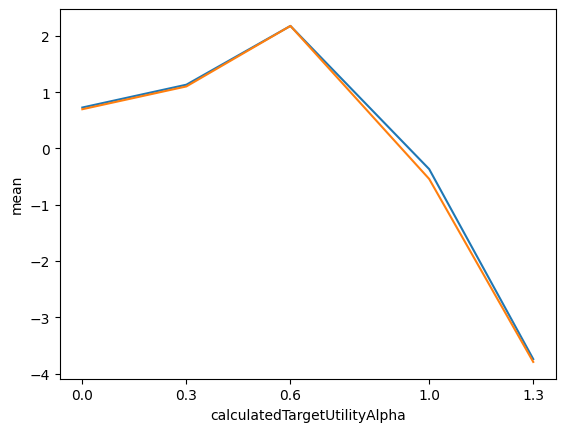

In [ ]:
# Just for test: Comparing utility curves
sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
    sourceDomain = "imdb", 
    targetDomain = "cora",
    target_targetPredicate = None,
    weightID = None,
    mappingID = None
)
sourceTargetMetricsDF = pd.merge(sourceTargetTransferLearningDF, transferLearningMetricsDF, left_on = "id", right_on = "experimentID", how = "left")
utilityColumns = [column for column in sourceTargetMetricsDF.columns if "utility@targetAlpha" in column]
sourceTargetMetricsDF = sourceTargetMetricsDF[[
    "id", "fold", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "mappingID", "mappingShortID",
    "weightID", "weightShortID", "cll", "aucROC", "aucPR", "prec", "rec", "f1", "threshold", 
    *utilityColumns
]]

bestExperimentID = sourceTargetMetricsDF.groupby("id")[["aucROC"]].mean().sort_values("aucROC").iloc[-1]
bestExperimentDF = sourceTargetMetricsDF[sourceTargetMetricsDF.id == bestExperimentId]
bestExperimentUtilityCurveDF = bestExperimentDF[["targetUtilityAlpha", *utilityColumns]]
bestExperimentUtilityCurveDF = pd.melt(bestExperimentUtilityCurveDF, id_vars = ["targetUtilityAlpha"])
bestExperimentUtilityCurveDF.columns = ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha", "utilityValue"]
bestExperimentUtilityCurveDF["calculatedTargetUtilityAlpha"] = bestExperimentUtilityCurveDF.calculatedTargetUtilityAlpha.apply(
    lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
)
bestExperimentUtilityCurveDF = bestExperimentUtilityCurveDF.groupby(
    ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha"]
).agg(["mean", "std", "count"])["utilityValue"].reset_index()

similarExperimentsDF = sourceTargetMetricsDF[
    (sourceTargetMetricsDF.mappingShortID == bestExperimentDF.iloc[0].mappingShortID) &
    (sourceTargetMetricsDF.weightShortID == bestExperimentDF.iloc[0].weightShortID) &
    (sourceTargetMetricsDF.utilityAlphaSetIter == bestExperimentDF.iloc[0].utilityAlphaSetIter) &
    (sourceTargetMetricsDF.sourceUtilityAlpha == bestExperimentDF.iloc[0].sourceUtilityAlpha)
]
similarExperimentsUtilityCurveDF = similarExperimentsDF[["targetUtilityAlpha", *utilityColumns]]
similarExperimentsUtilityCurveDF = pd.melt(similarExperimentsUtilityCurveDF, id_vars = ["targetUtilityAlpha"])
similarExperimentsUtilityCurveDF.columns = ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha", "utilityValue"]
similarExperimentsUtilityCurveDF["calculatedTargetUtilityAlpha"] = similarExperimentsUtilityCurveDF.calculatedTargetUtilityAlpha.apply(
    lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
)
similarExperimentsUtilityCurveDF = similarExperimentsUtilityCurveDF.groupby(
    ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha"]
).agg(["mean", "std", "count"])["utilityValue"].reset_index()
similarExperimentsUtilityCurveDF = similarExperimentsUtilityCurveDF[
    similarExperimentsUtilityCurveDF.optimizedTargetUtilityAlpha == similarExperimentsUtilityCurveDF.calculatedTargetUtilityAlpha
]
    
sns.lineplot(
    data = bestExperimentUtilityCurveDF,
    x = "calculatedTargetUtilityAlpha",
    y = "mean"
)

sns.lineplot(
    data = similarExperimentsUtilityCurveDF,
    x = "calculatedTargetUtilityAlpha",
    y = "mean"
)

_ = plt.xticks([0.0,0.3,0.6,1.0,1.3])

In [ ]:
similarExperimentsUtilityCurveDF

,optimizedTargetUtilityAlpha,calculatedTargetUtilityAlpha,mean,std,count
0,0.0,0.0,0.696867,0.009373,5
6,0.3,0.3,1.102193,0.023230,5
12,0.6,0.6,2.177151,0.033713,5
18,1.0,1.0,-0.541738,0.060948,5
24,1.3,1.3,-3.793040,0.130627,5


In [ ]:
bestExperimentUtilityCurveDF

,optimizedTargetUtilityAlpha,calculatedTargetUtilityAlpha,mean,std,count
0,0.6,0.0,0.727226,0.028813,5
1,0.6,0.3,1.132750,0.031221,5
2,0.6,0.6,2.177151,0.033713,5
3,0.6,1.0,-0.367147,0.036810,5
4,0.6,1.3,-3.742283,0.038404,5


# **IMDB To Cora**

Learning from scratch using original RDN-Boost and data from cora:
Experiment ID: 816f88e322ad9332974b410b99743c591cfb28291770844b23d5ab2e50cf7967
AUC-ROC: 0.6461978 +- 0.14654365685419482
AUC-PR: 0.4731909999999999 +- 0.1513640834098367


Best AUC-ROC performance:
Experiment ID: d411b3e607d6ccf16855f9415a87ca7c51dad9f3432cffb89cfcb5be2f25acd4
Source utility alpha: 1.0
Target utility alpha: 0.6
Utility alpha set iteration: 3.0
Relation mapping: {'movie': 'samevenue', 'workedunder': None, 'female': None, 'actor': None, 'director': None, 'genre': 'haswordvenue'}
Term type mapping: {'movie': 'venue', 'person': 'venue', 'genre': 'word'}
AUC-ROC: 0.916371 +- 0.015217182541456212
AUC-PR: 0.7668284000000001 +- 0.04664883179459051


Best AUC-PR performance:
Experiment ID: bd52831309ada286d62e64cf24e949319f73c548fd60103f5c595d2a3b80e1c2
Source utility alpha: 0.3
Target utility alpha: 1.0
Utility alpha set iteration: 3.0
Relation mapping: {'workedunder': 'samevenue', 'female': None, 'actor': Non

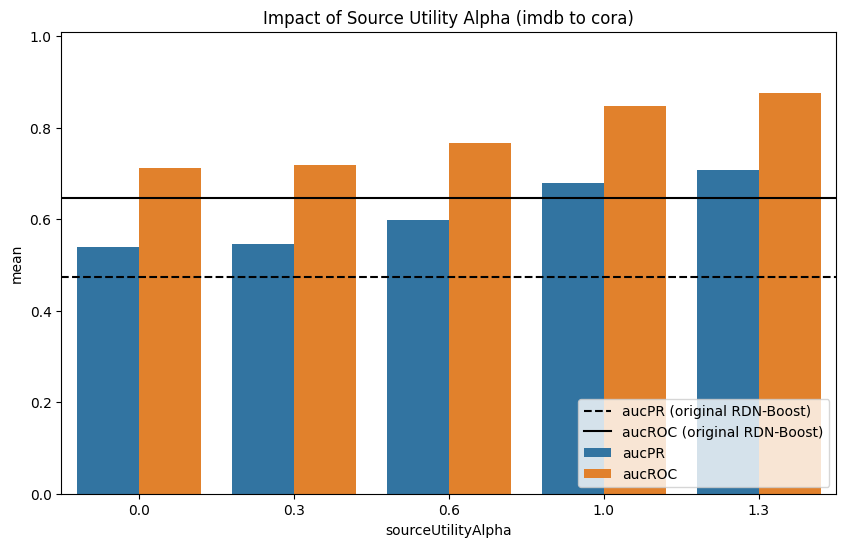

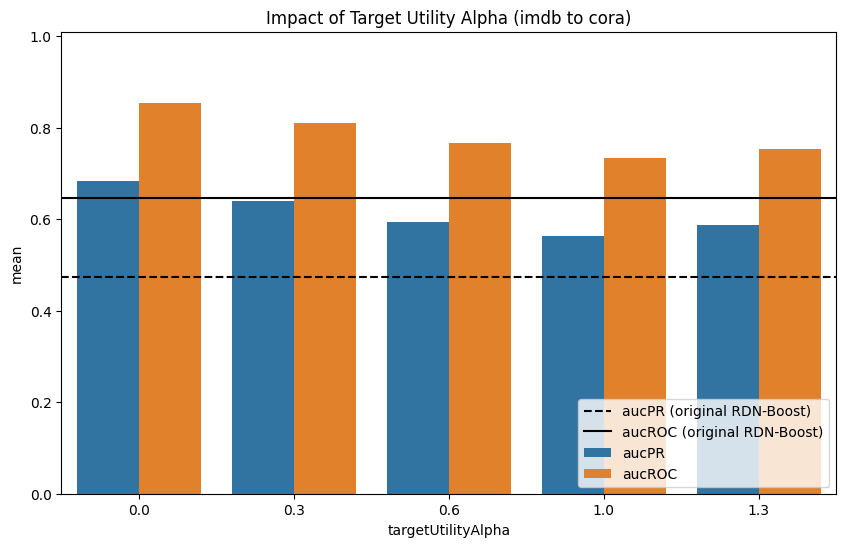

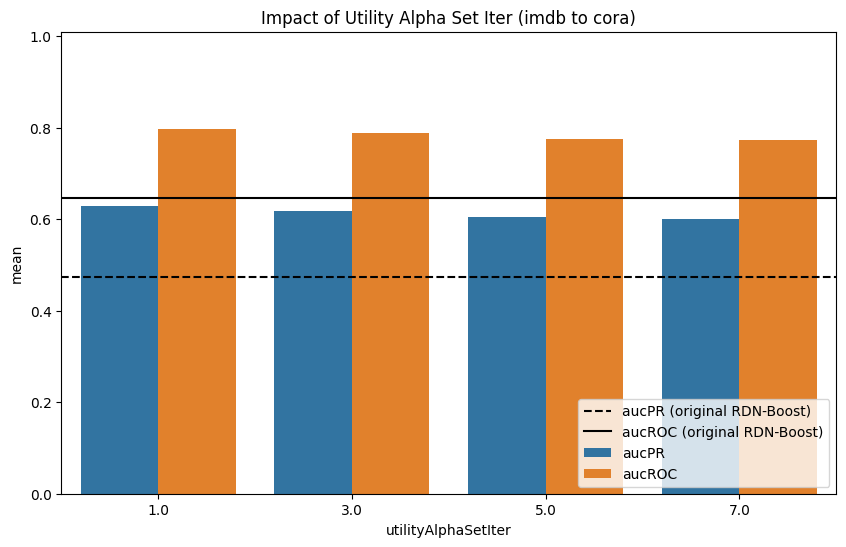

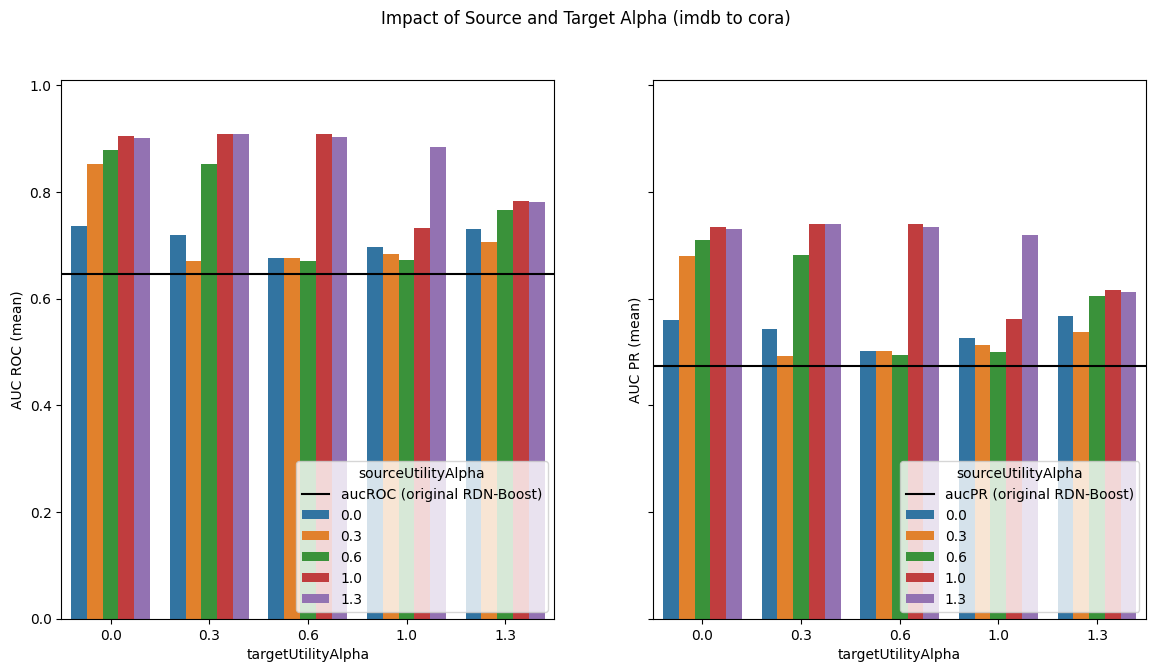

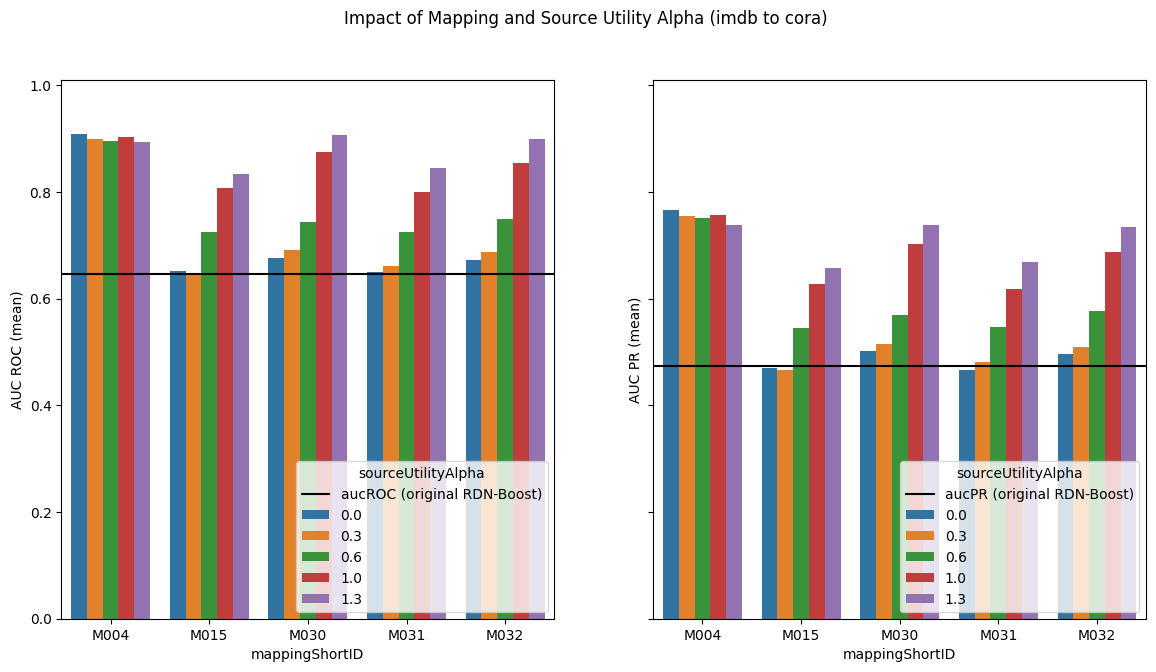

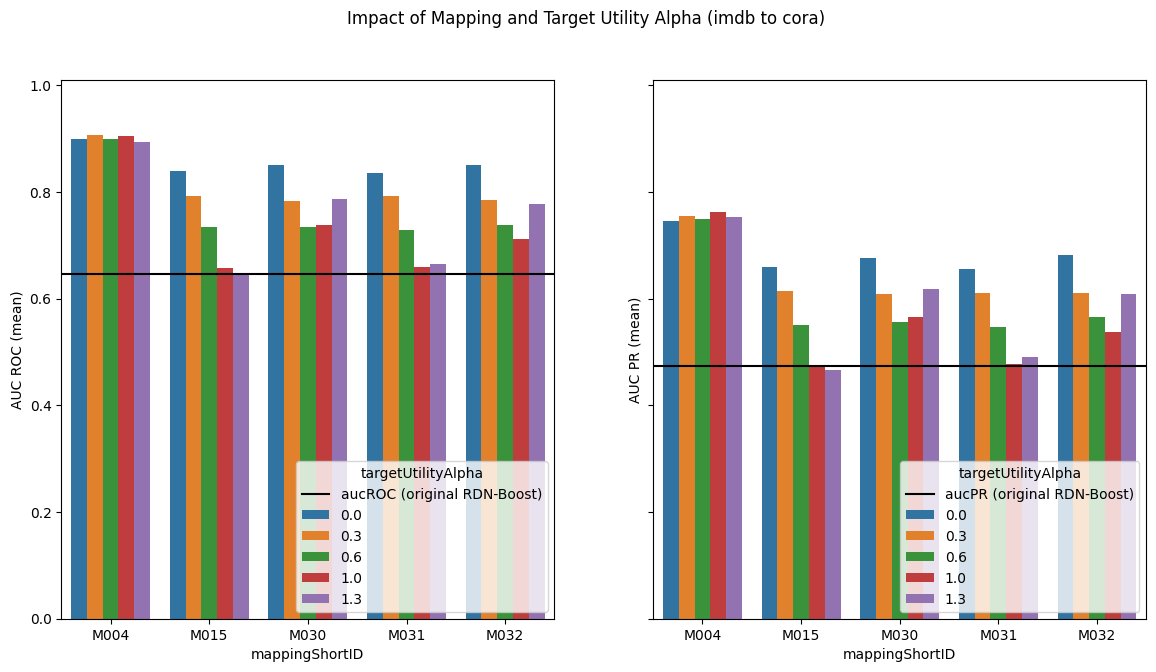

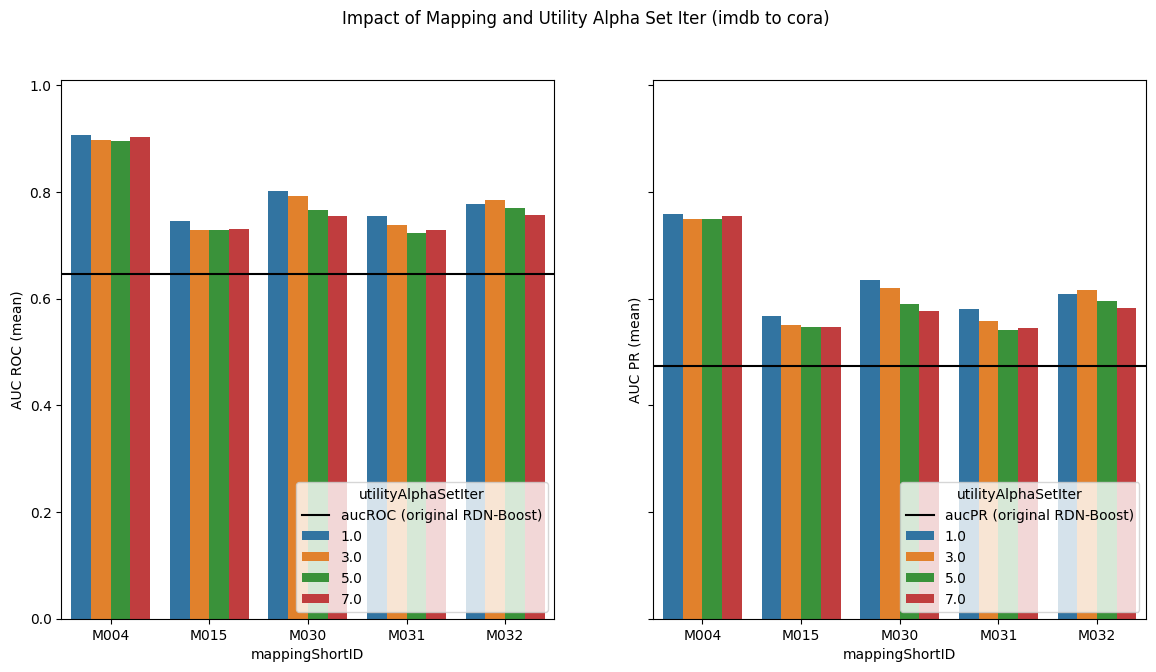

In [ ]:
analysisVariables = runAnalysis("imdb", "cora")

# **Cora to IMDB**

Learning from scratch using original RDN-Boost and data from imdb:
Experiment ID: 51d101f2e9cfac1aa4edb1f463accf3f6b5d41f573f52ae1e90a28db8ad7b022
AUC-ROC: 1.0 +- 0.0
AUC-PR: 1.0 +- 0.0


Best AUC-ROC performance:
Experiment ID: 7d68097569a8ec755d4ca190dbe0779f42ab54909bb0a13c325720702c9d839d
Source utility alpha: 0.0
Target utility alpha: 0.6
Utility alpha set iteration: 1.0
Relation mapping: {'venue': 'workedunder', 'sameauthor': None, 'samebib': None, 'sametitle': None, 'samevenue': None, 'author': None, 'title': 'genre', 'haswordauthor': None, 'haswordtitle': None, 'haswordvenue': None}
Term type mapping: {'class': 'person', 'venue': 'person', 'title': 'genre'}
AUC-ROC: 1.0 +- 0.0
AUC-PR: 1.0 +- 0.0


Best AUC-PR performance:
Experiment ID: 396a63c068864d171cb3eeb5c9340cea81e4e0ce00592bd492485edfba59c5ff
Source utility alpha: 0.0
Target utility alpha: 1.0
Utility alpha set iteration: 1.0
Relation mapping: {'venue': 'workedunder', 'sameauthor': None, 'samebib': None, 'sametitle': No

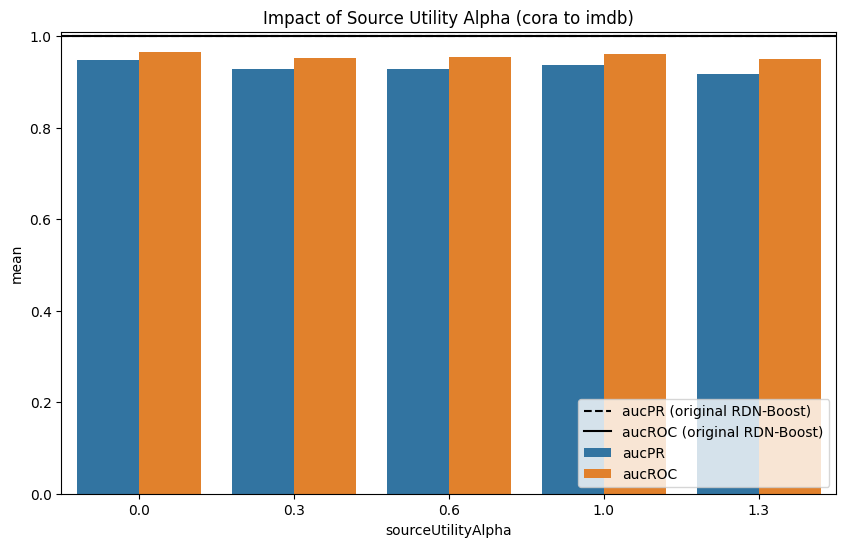

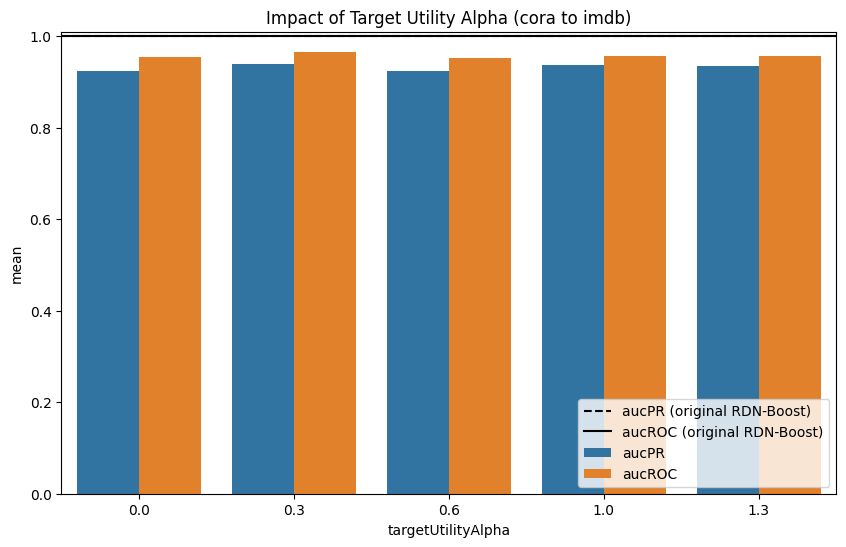

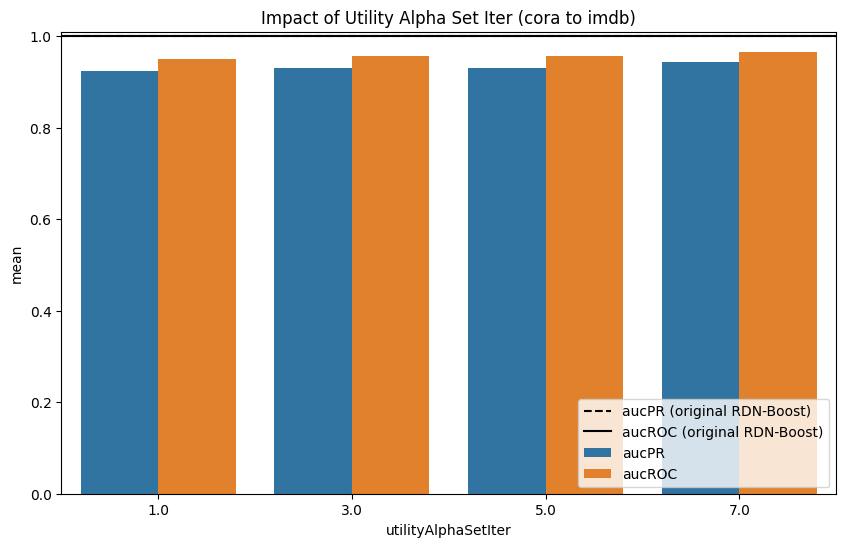

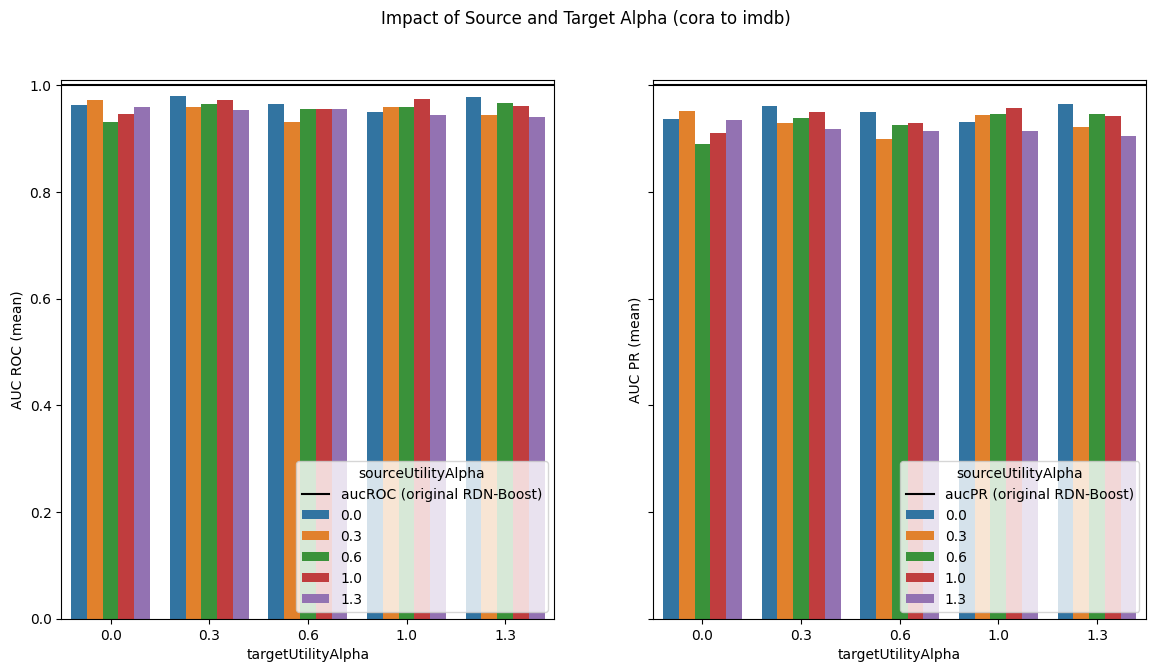

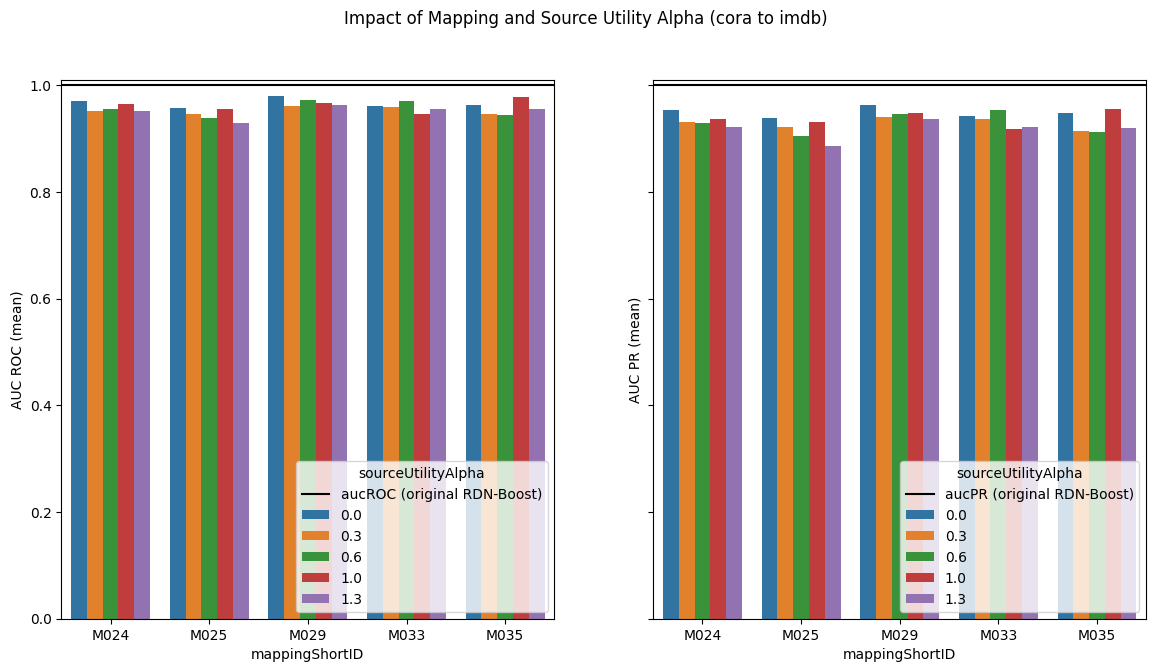

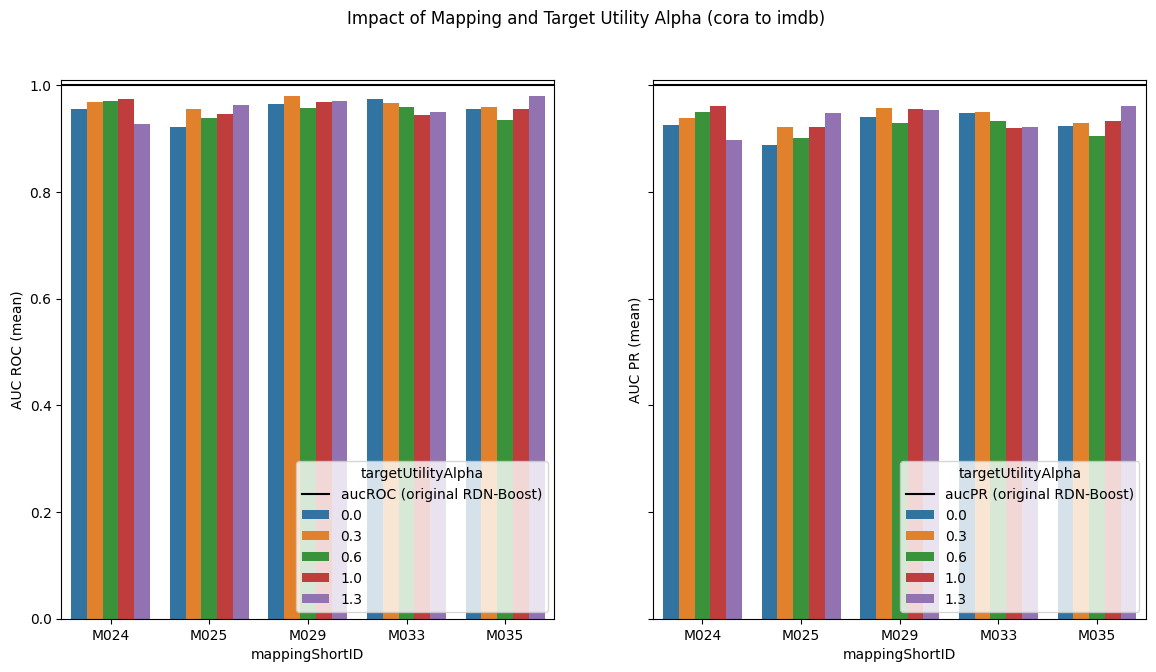

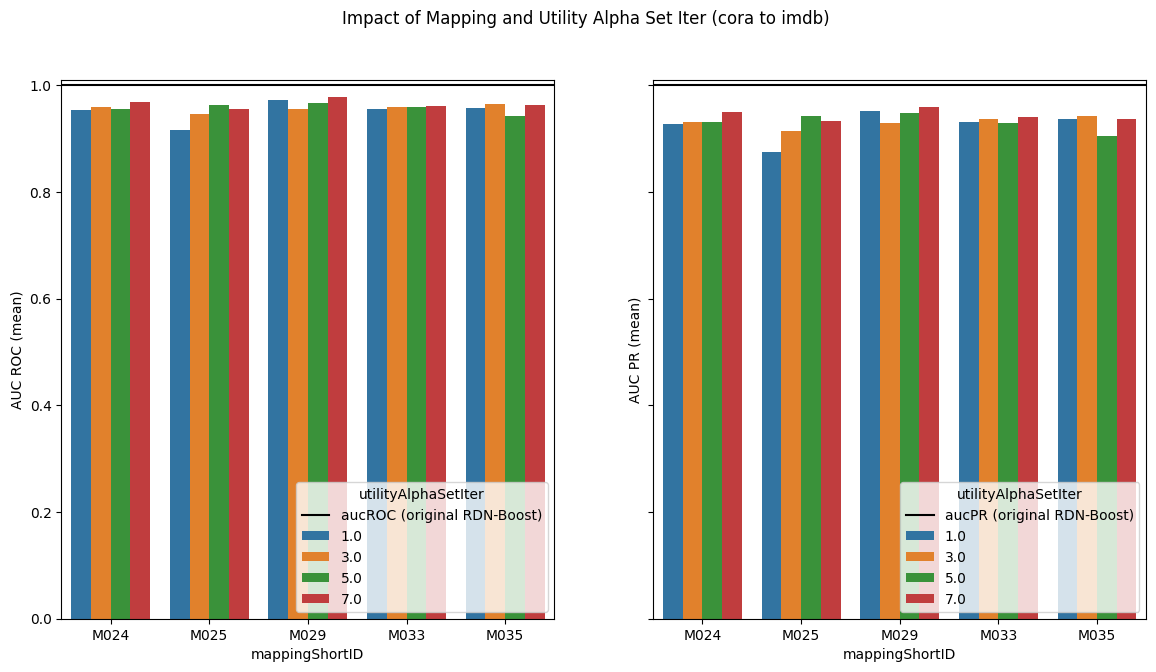

In [ ]:
analysisVariables = runAnalysis("cora", "imdb")

# **IMDB To UW-CSE**

Learning from scratch using original RDN-Boost and data from uwcse:
Experiment ID: c0b61053859b77b0901fecdeaad7db8405a209cd76add3a212044068dae41802
AUC-ROC: 0.9216517999999999 +- 0.04053925224643394
AUC-PR: 0.7834100000000002 +- 0.09789070165240414


Best AUC-ROC performance:
Experiment ID: cff308b6d981af7b6886946b98ded5588cf91c2749eb39ccc7ad79051e6f129a
Source utility alpha: 0.3
Target utility alpha: 0.6
Utility alpha set iteration: 3.0
Relation mapping: {'movie': 'advisedby', 'workedunder': 'tempadvisedby', 'female': None, 'actor': 'professor', 'director': 'student', 'genre': 'yearsinprogram'}
Term type mapping: {'movie': 'person', 'person': 'person', 'genre': 'year'}
AUC-ROC: 0.9373754 +- 0.01832245494741355
AUC-PR: 0.8223718 +- 0.055020799241741275


Best AUC-PR performance:
Experiment ID: f3ae43b9215c2493380521cec736ff40fe7b9e98a9e093af156ec3ca880807cc
Source utility alpha: 1.0
Target utility alpha: 0.6
Utility alpha set iteration: 1.0
Relation mapping: {'movie': 'advisedby', 'wor

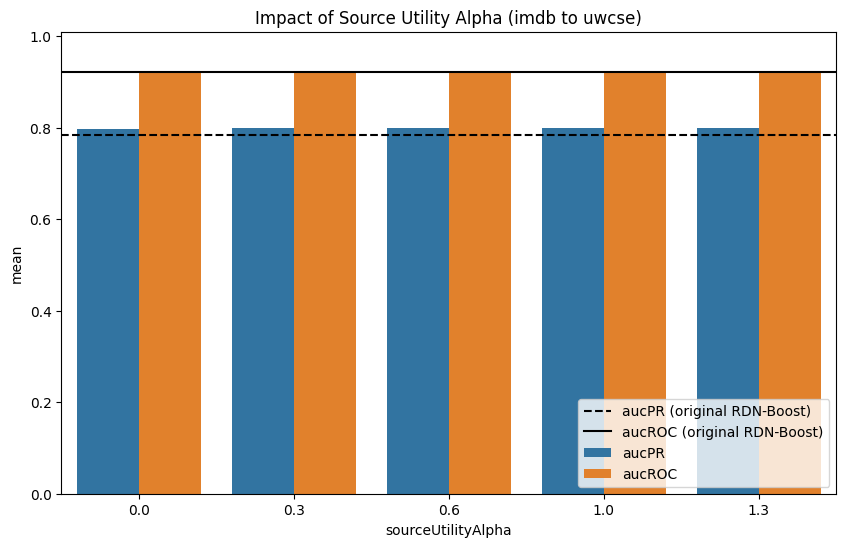

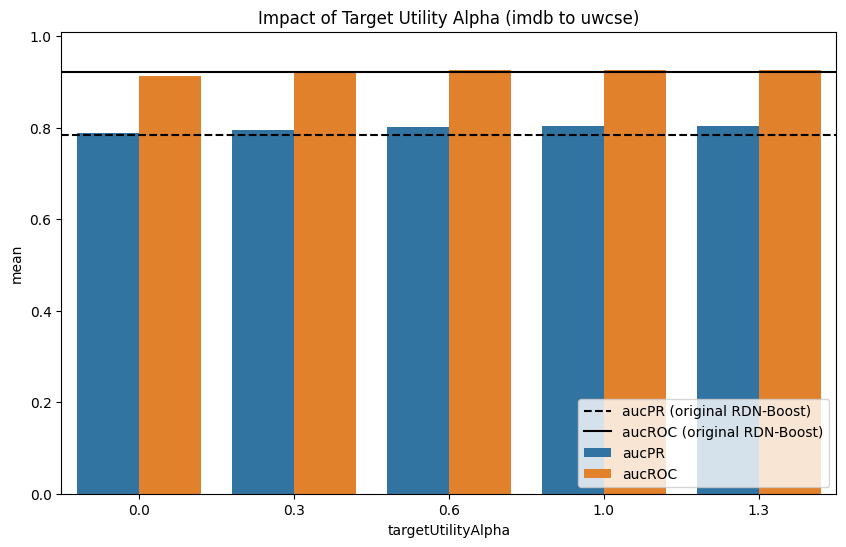

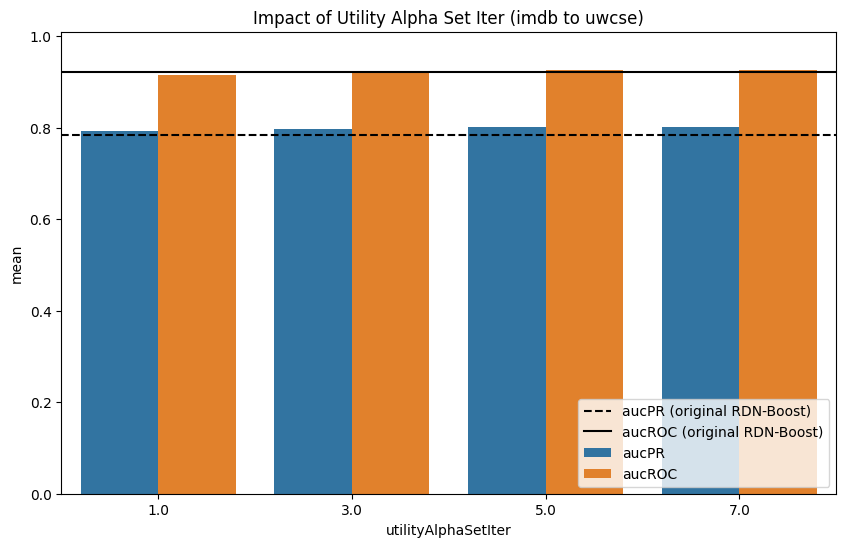

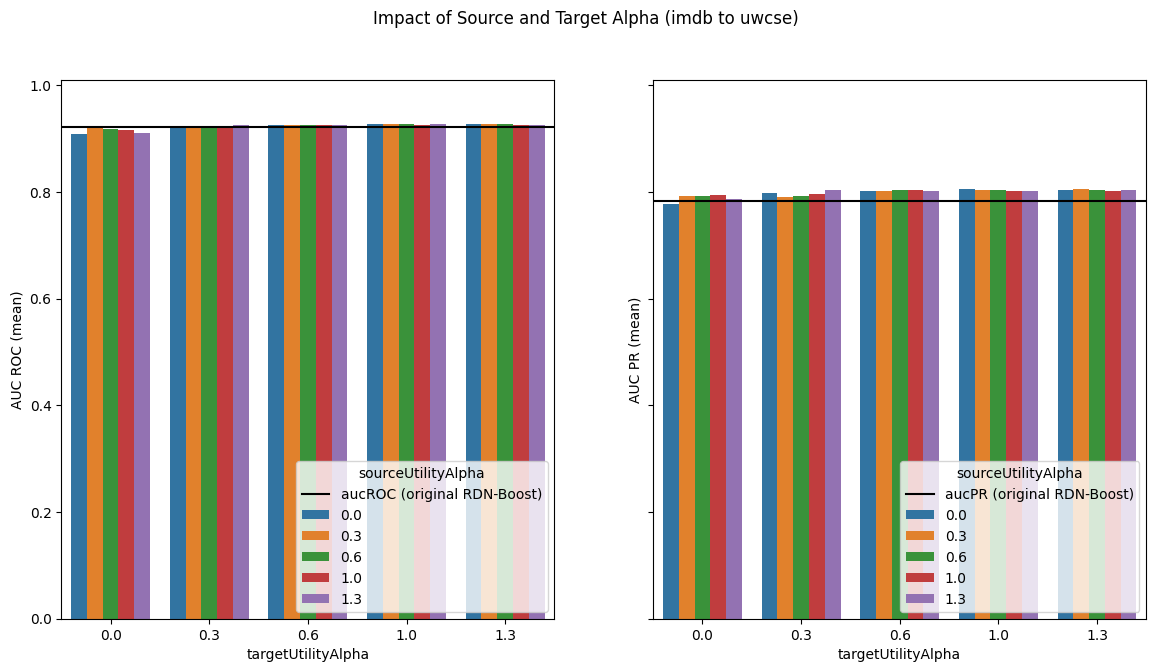

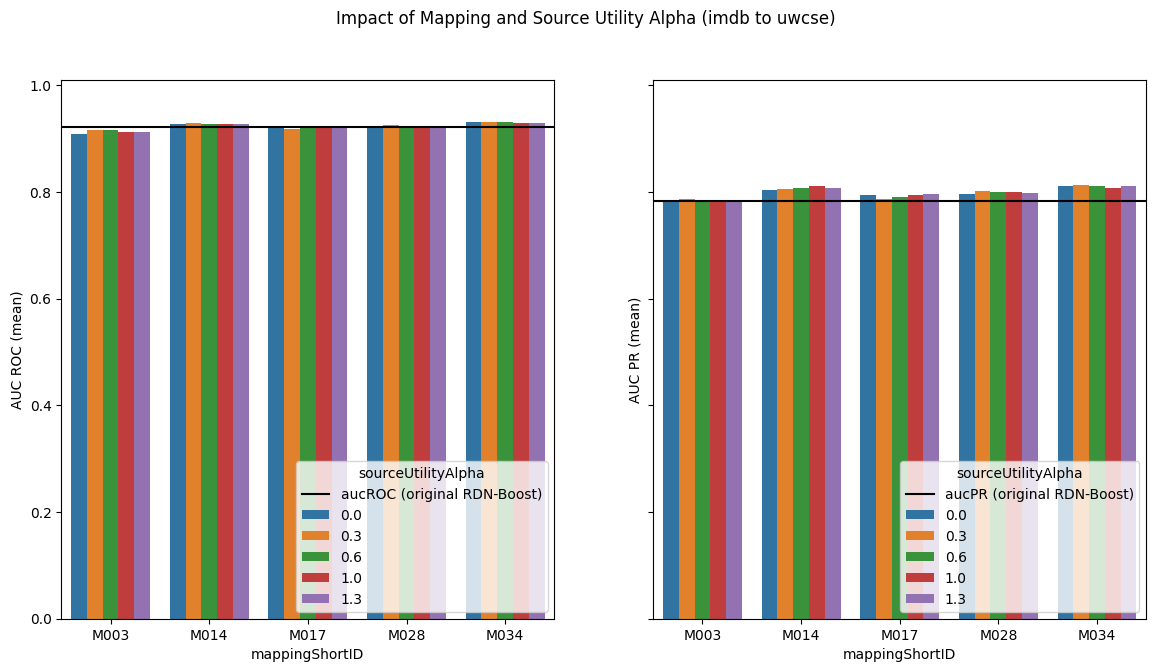

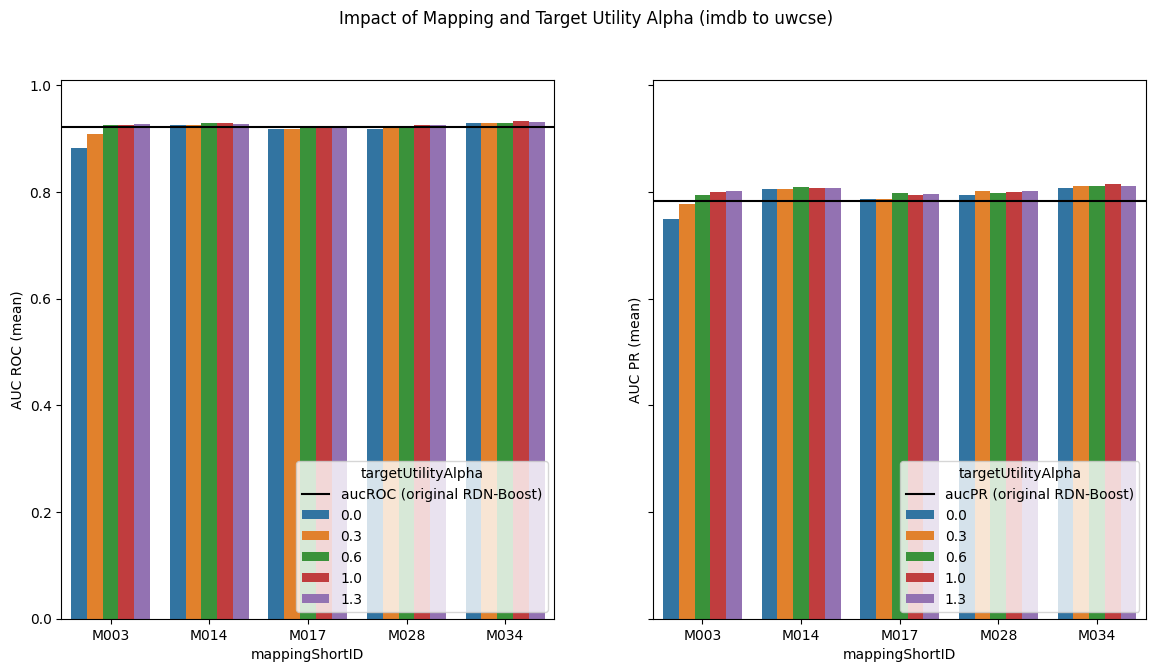

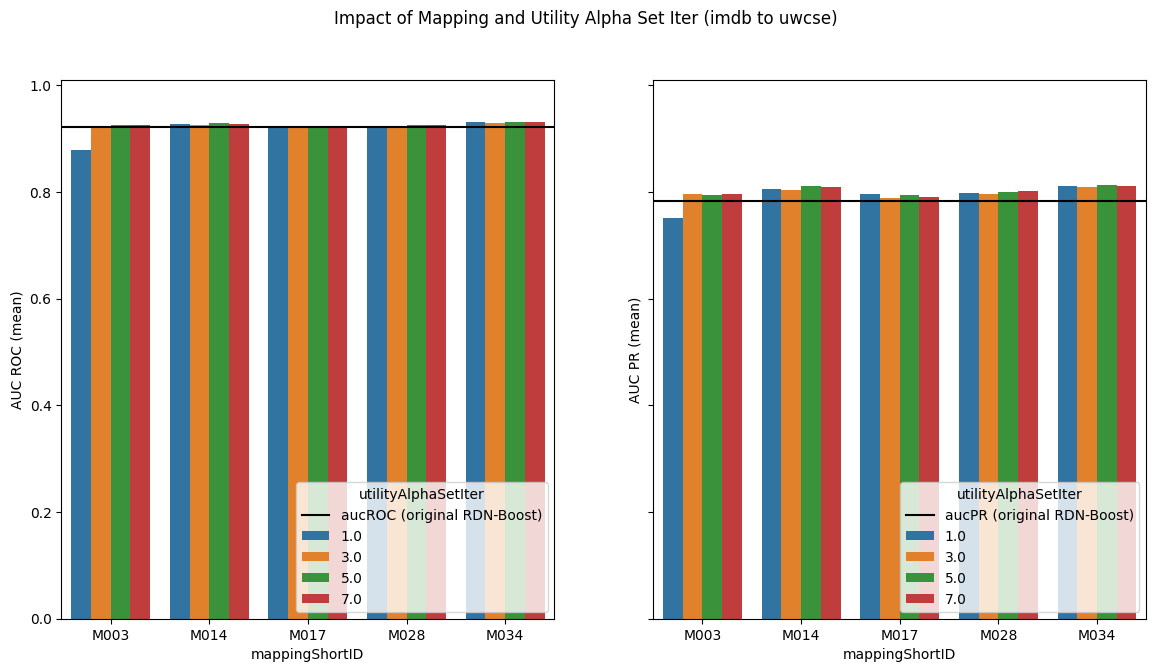

In [ ]:
analysisVariables = runAnalysis("imdb", "uwcse")

# **Twitter To Yeast**

Learning from scratch using original RDN-Boost and data from yeast:
Experiment ID: 6a9f022b5fc34609ec98a9898cafb1845f9e40acb61a13255e18e0fdd935f419
AUC-ROC: 0.86700175 +- 0.08860163915479595
AUC-PR: 0.811415 +- 0.10903608381937908


Best AUC-ROC performance:
Experiment ID: 18589a181852560d080232fde87594a6d37c0440e4cf2dbb3295fd0a40e9ea89
Source utility alpha: 0.3
Target utility alpha: 1.3
Utility alpha set iteration: 3.0
Relation mapping: {'tweets': 'proteinclass', 'recursion_tweets': 'recursion_proteinclass', 'accounttype': 'interaction', 'follows': None}
Term type mapping: {'account': 'protein', 'word': 'class', 'type': 'protein'}
AUC-ROC: 0.996109 +- 0.0012314251905820445
AUC-PR: 0.989047 +- 0.004348237880643933


Best AUC-PR performance:
Experiment ID: 6686ac04ddaf3e507af9c6b94b8f868e37c2d1a12fdccecaa8770b8892934d76
Source utility alpha: 0.0
Target utility alpha: 0.6
Utility alpha set iteration: 1.0
Relation mapping: {'accounttype': 'proteinclass', 'recursion_accounttype': 'recursio

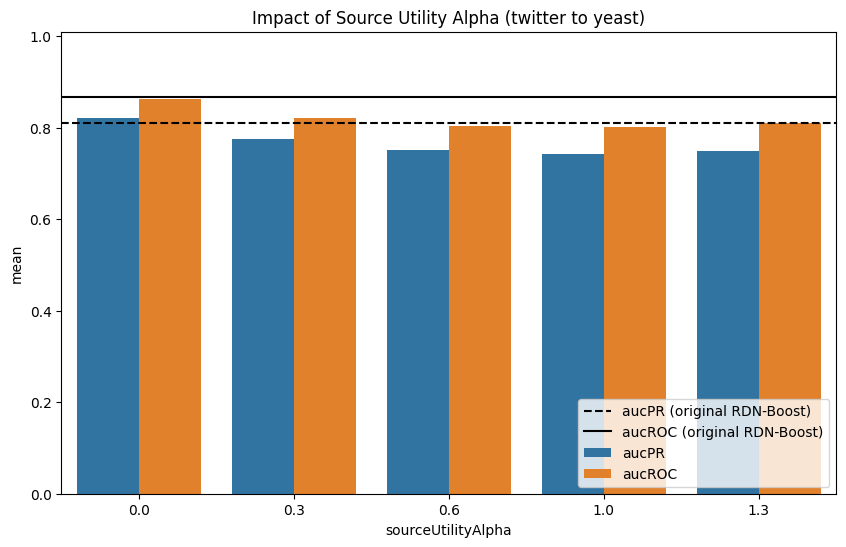

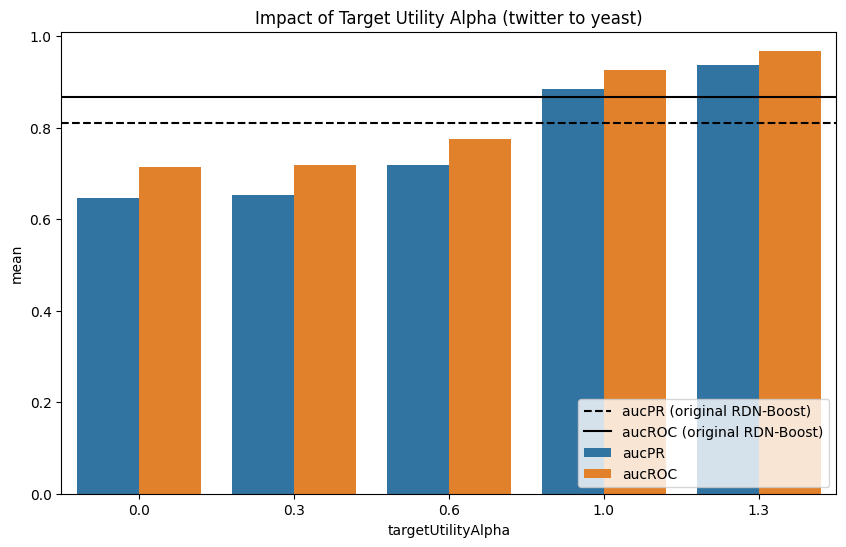

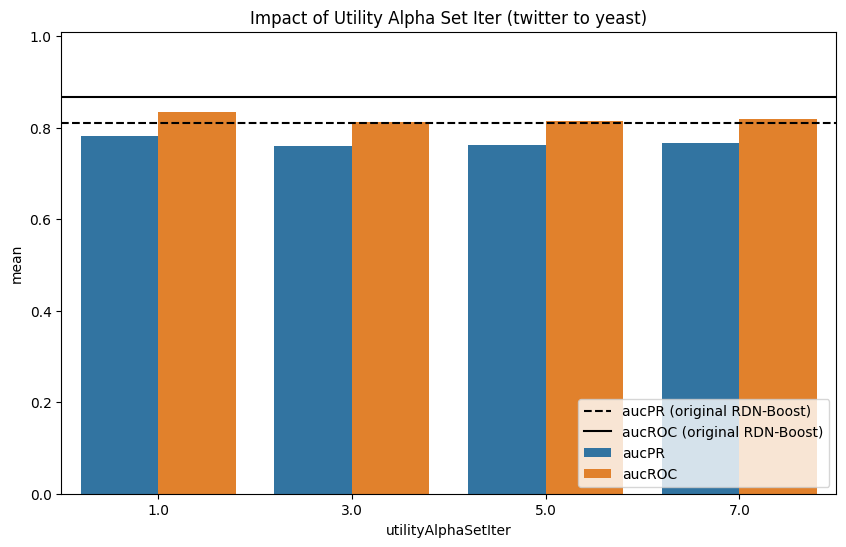

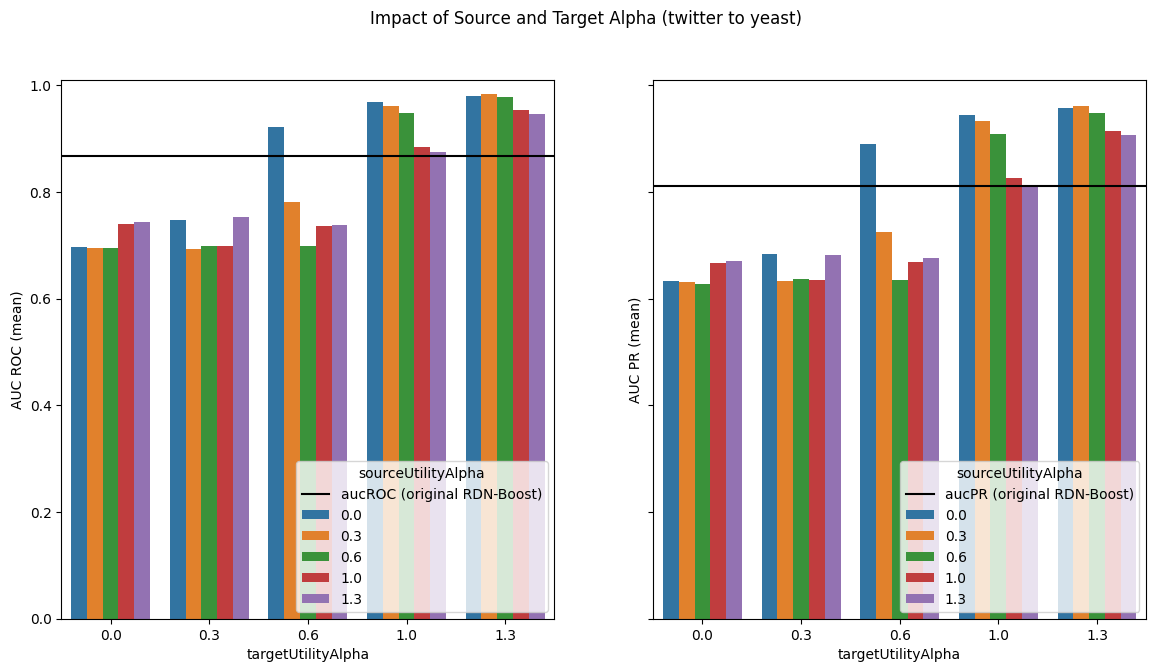

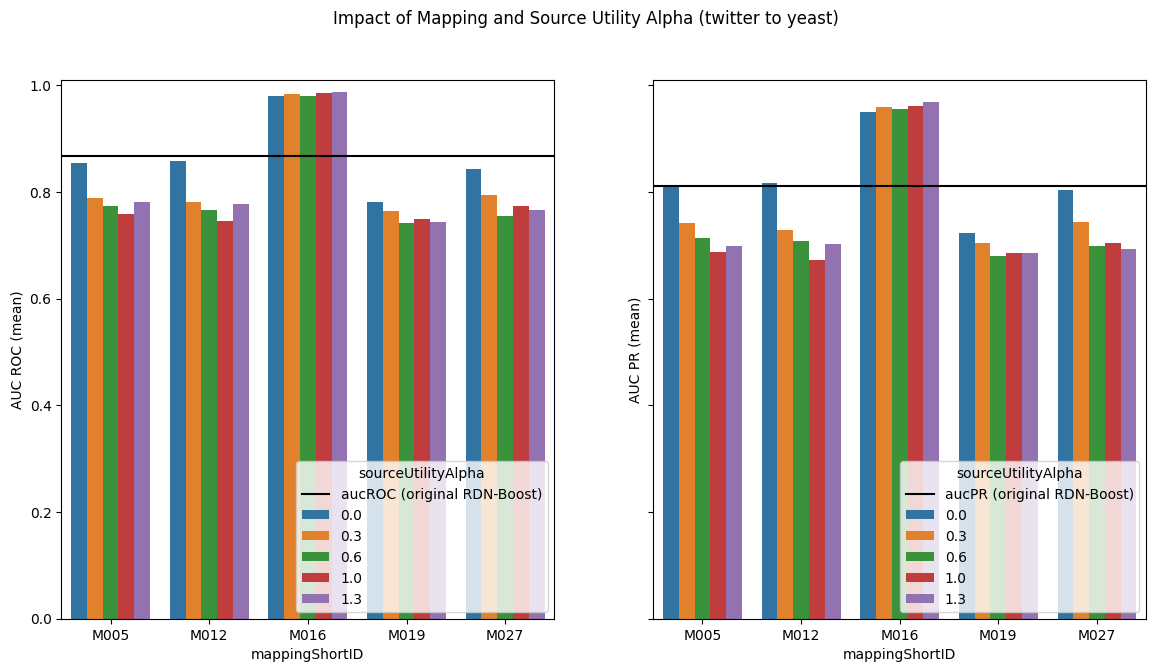

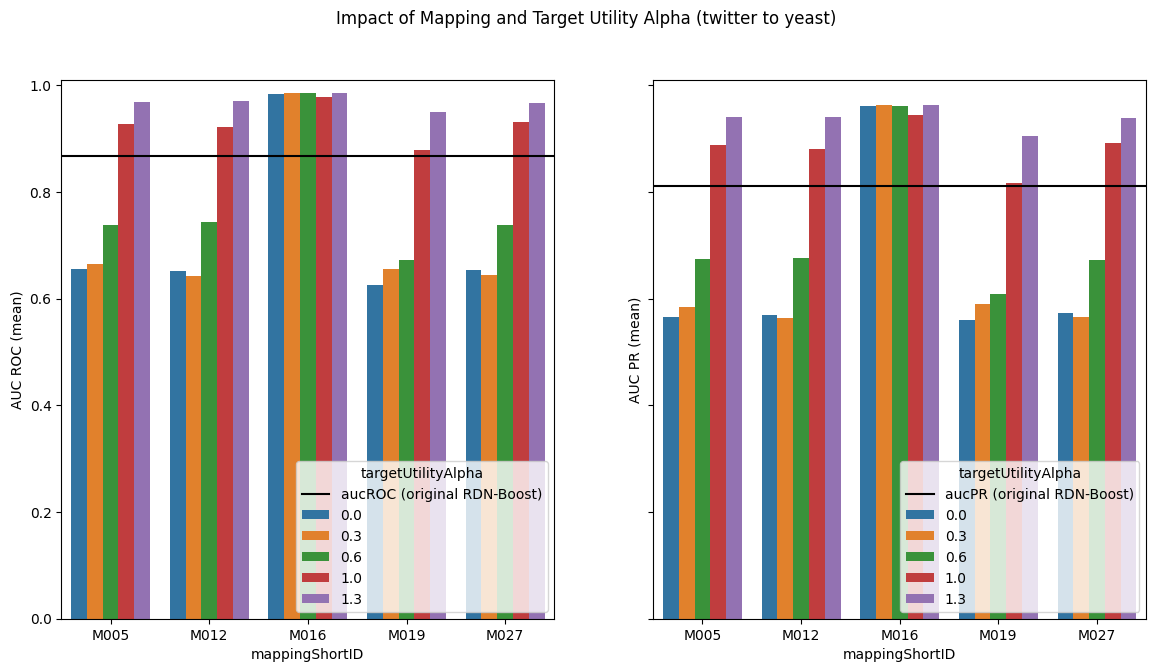

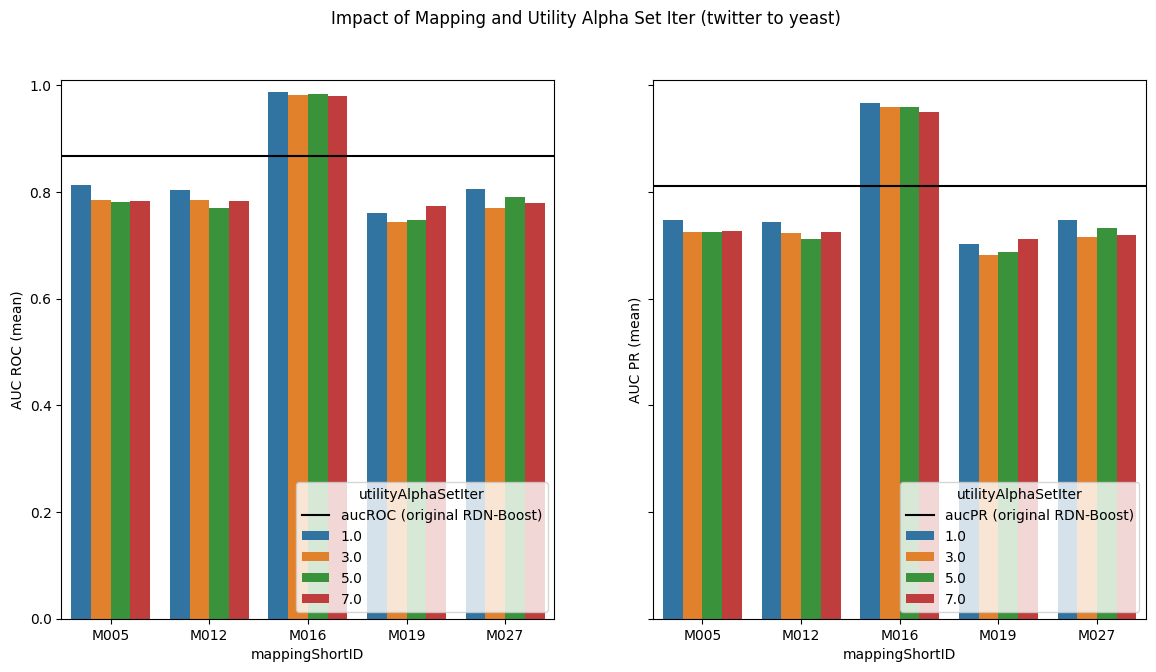

In [ ]:
analysisVariables = runAnalysis("twitter", "yeast")

# **Yeast To Twitter**

Learning from scratch using original RDN-Boost and data from twitter:
Experiment ID: b66e86ba8b85a4ad471123e9d4010515430a0c49c6fa23f7496e373ed78183cf
AUC-ROC: 0.993062 +- 0.00384383246253007
AUC-PR: 0.982757 +- 0.011078949047630836


Best AUC-ROC performance:
Experiment ID: c63e9cb4a8ec151ba1321def0f74f2b91a15214a9a8baa838cbaf8d8c6e4b826
Source utility alpha: 0.3
Target utility alpha: 0.3
Utility alpha set iteration: 3.0
Relation mapping: {'function': 'accounttype', 'recursion_function': 'recursion_accounttype', 'location': 'tweets', 'interaction': None, 'proteinclass': None, 'enzyme': 'follows', 'complex': None, 'phenotype': None}
Term type mapping: {'protein': 'account', 'fun': 'type', 'loc': 'word', 'enz': 'account'}
AUC-ROC: 0.994888 +- 0.0043345645686735145
AUC-PR: 0.987153 +- 0.011602208065708934


Best AUC-PR performance:
Experiment ID: b45ead65a1670ade43e08d3f429838d56e21dd723ebd05a0db46df3323738b3e
Source utility alpha: 0.0
Target utility alpha: 1.3
Utility alpha set iteration

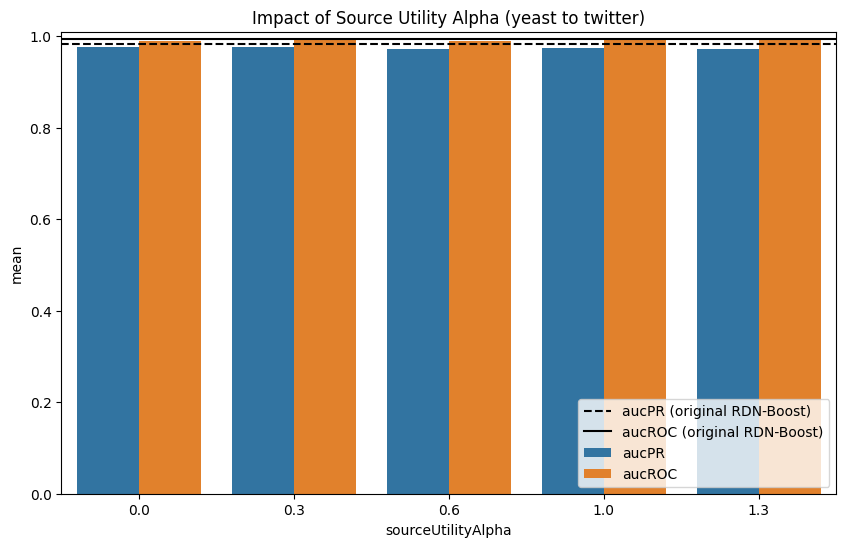

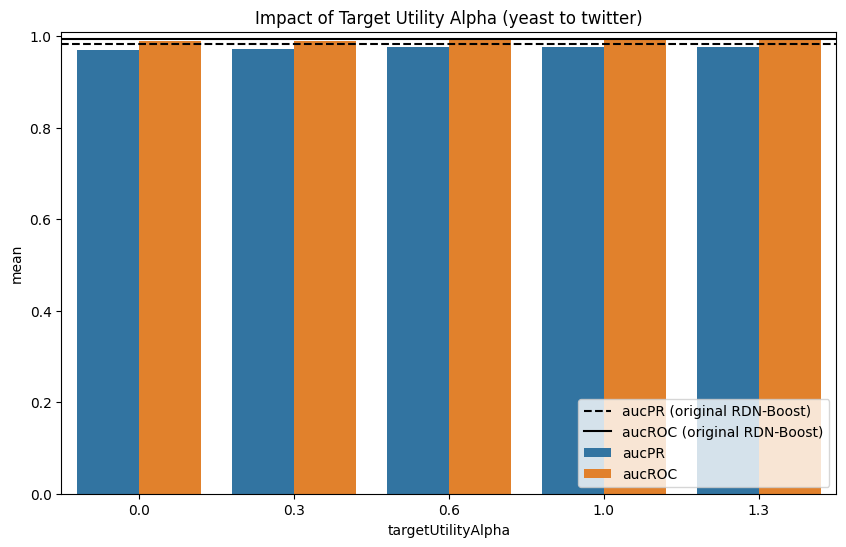

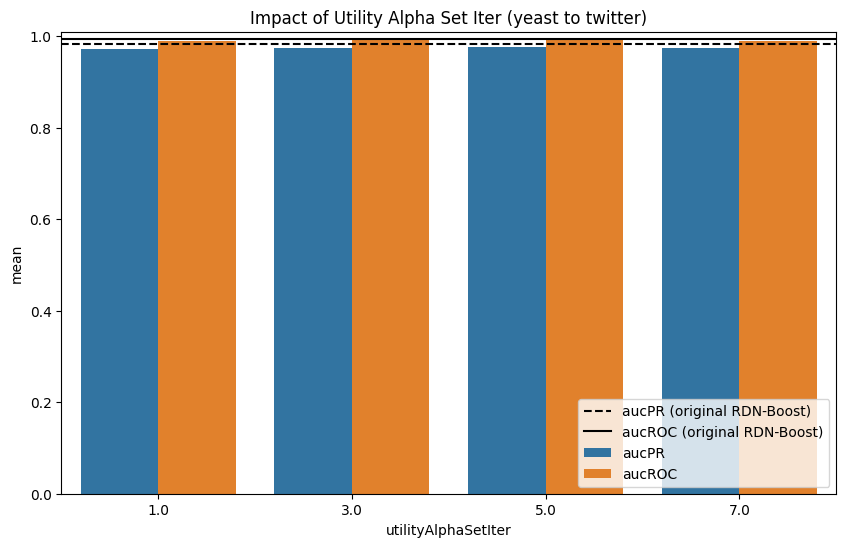

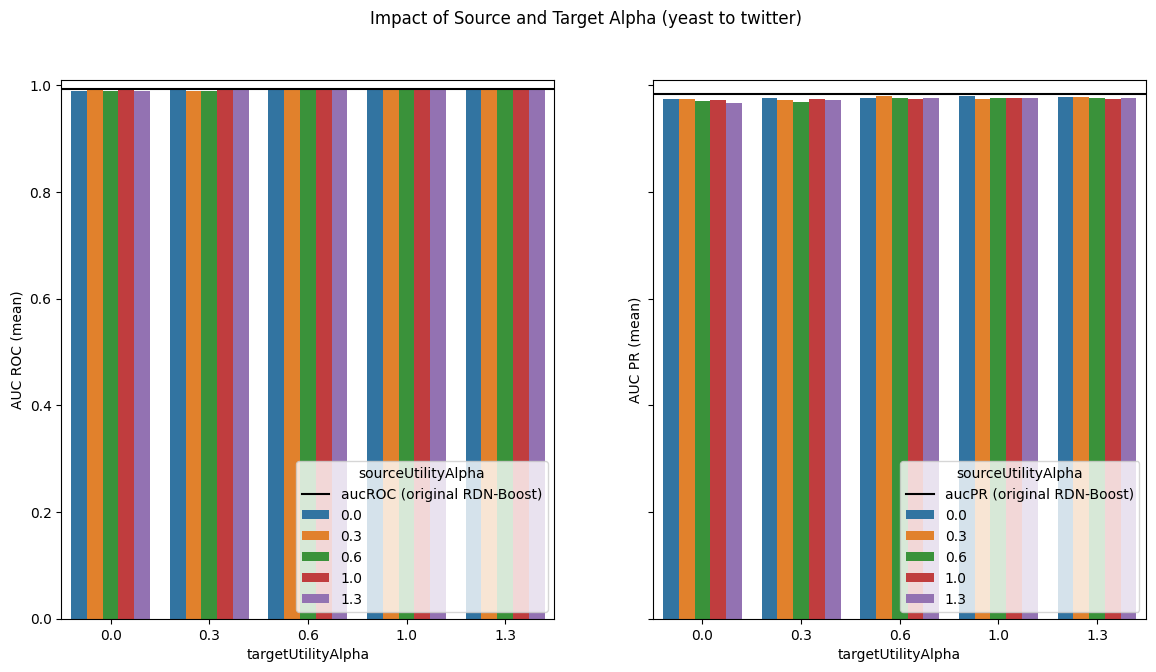

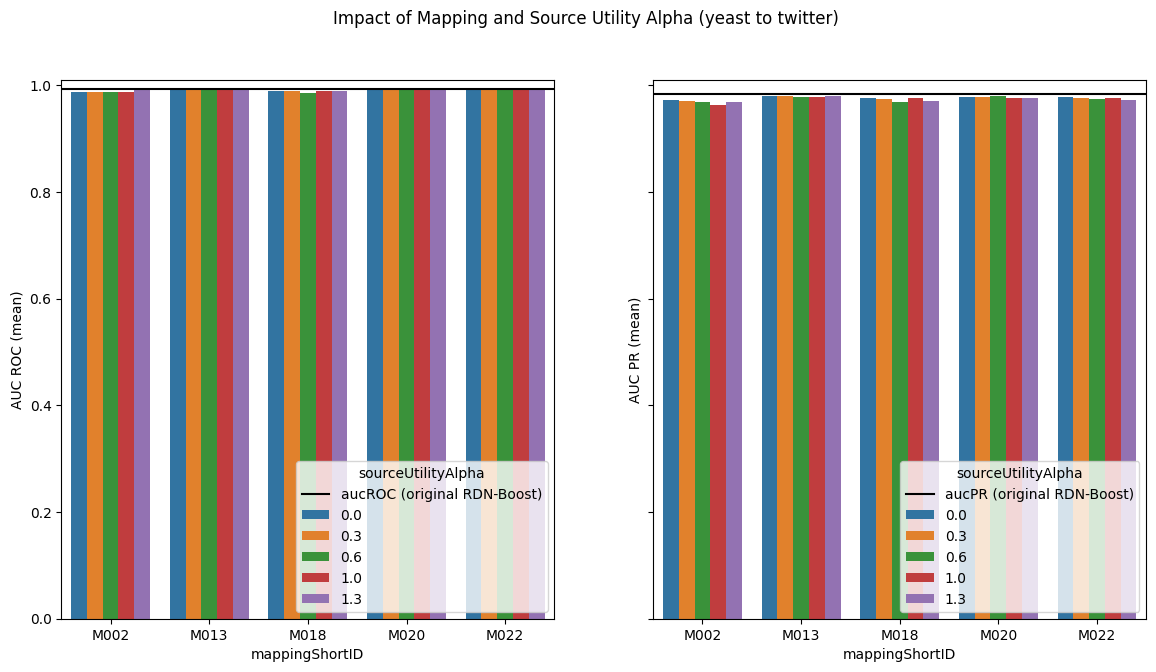

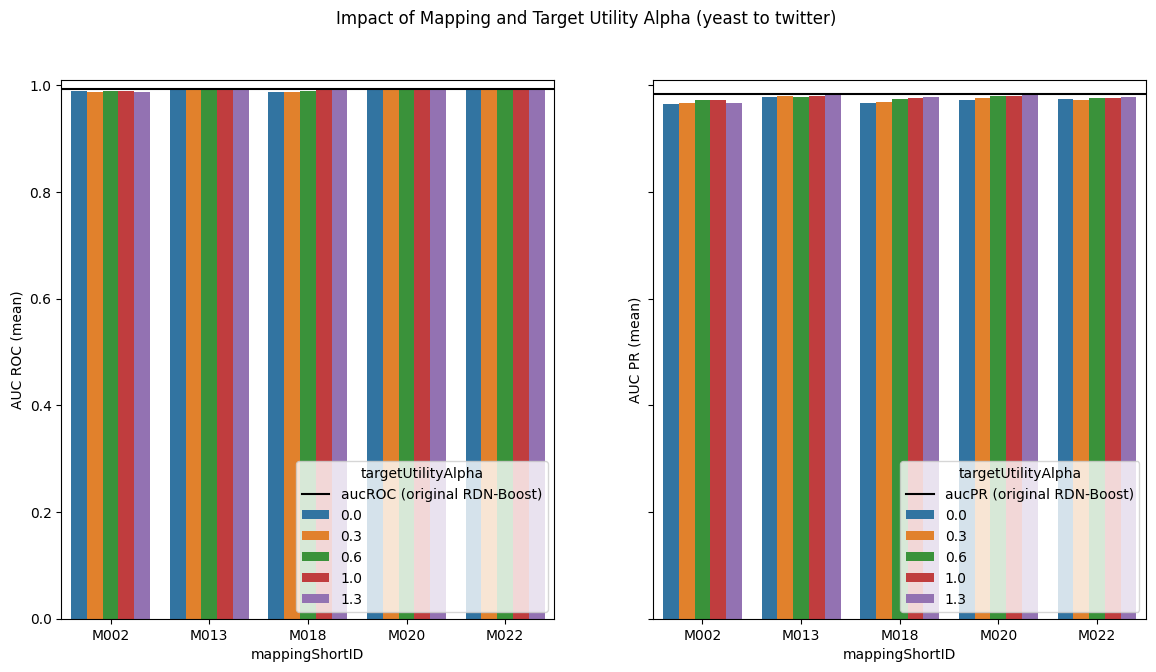

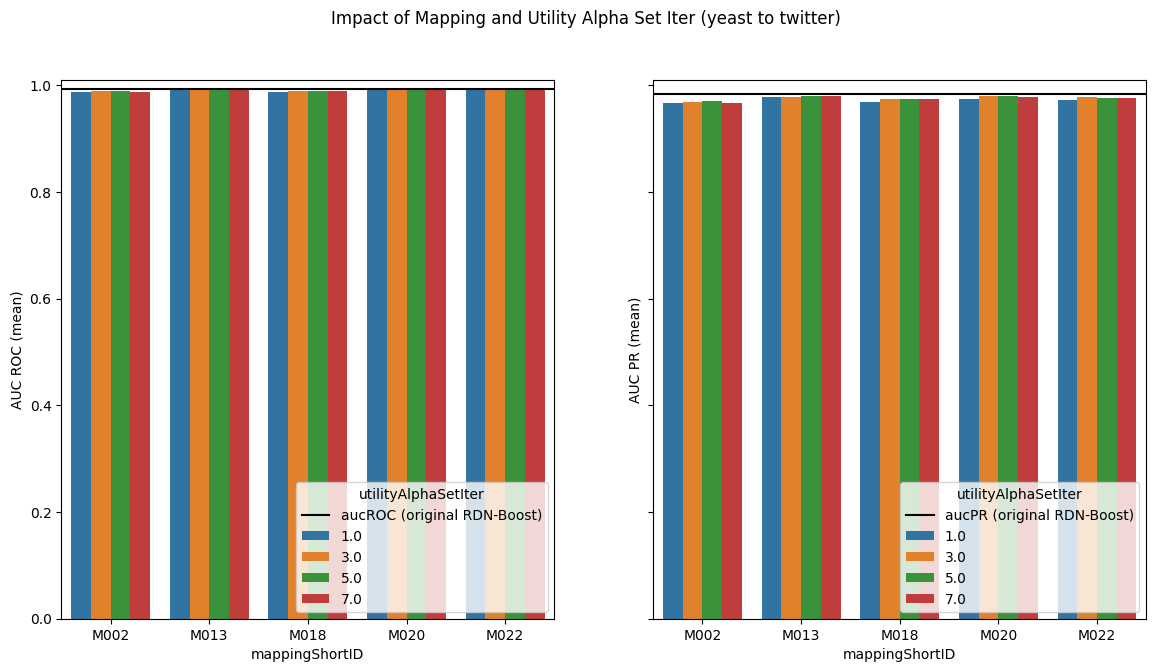

In [ ]:
analysisVariables = runAnalysis("yeast", "twitter")

In [ ]:
analysisVariables["sourceUtilityAlphaPerformanceDF"]

aucPR                                                    \
                    count      mean       std       min       25%       50%   
sourceUtilityAlpha                                                            
0.0                 200.0  0.976372  0.014404  0.906523  0.969871  0.977758   
0.3                 200.0  0.975719  0.015330  0.896298  0.968561  0.975411   
0.6                 200.0  0.973304  0.015532  0.876030  0.966367  0.973310   
1.0                 200.0  0.973621  0.014845  0.882139  0.966066  0.973448   
1.3                 200.0  0.973233  0.019761  0.762483  0.967367  0.972602   

                                       aucROC            ...            \
                         75%       max  count      mean  ...       75%   
sourceUtilityAlpha                                       ...             
0.0                 0.987760  0.998186  200.0  0.990630  ...  0.995343   
0.3                 0.988382  0.996548  200.0  0.990991  ...  0.995418   
0.6                 0.986552  0.996969  200.0  0.990298  ...  0.994929   
1.0                 0.986503  0.995885  200.0  0.991007  ...  0.995024   
1.3                 0.986319  0.995726  200.0  0.991120  ...  0.995000   

                                cll                                          \
                         max  count      mean       std       min       25%   
sourceUtilityAlpha                                                            
0.0                 0.999118  200.0 -0.210647  0.077117 -0.529302 -0.237904   
0.3                 0.998425  200.0 -0.198335  0.062350 -0.488707 -0.228169   
0.6                 0.998630  200.0 -0.195220  0.056296 -0.413090 -0.223544   
1.0                 0.998142  200.0 -0.183288  0.047037 -0.354046 -0.208856   
1.3                 0.998079  200.0 -0.182157  0.050749 -0.452674 -0.203868   

                                                  
                         50%       75%       max  
sourceUtilityAlpha                                
0.0                -0.195487 -0.155373 -0.110133  
0.3                -0.191601 -0.154940 -0.105142  
0.6                -0.181914 -0.155345 -0.108671  
1.0                -0.178250 -0.148265 -0.099014  
1.3                -0.175437 -0.146554 -0.108167  

[5 rows x 24 columns]

# **NELL Sports To NELL Finances**

Learning from scratch using original RDN-Boost and data from nell_finances:
Experiment ID: bf61e2b7f32e7599b7a4c2e147a01836132f2ca951dcf02c9642f97c877c9e1a
AUC-ROC: 0.7188293333333333 +- 0.051323095778931085
AUC-PR: 0.6289296666666667 +- 0.07084713953529338


Best AUC-ROC performance:
Experiment ID: 9d42911e8115f7e1f34b8333583d28b0bef5ccc46bcff5a7ba664af957adef29
Source utility alpha: 0.0
Target utility alpha: 1.3
Utility alpha set iteration: 7.0
Relation mapping: {'teamplaysinleague': 'companyeconomicsector', 'recursion_teamplaysinleague': 'recursion_companyeconomicsector', 'athleteledsportsteam': None, 'athleteplaysforteam': 'acquired', 'athleteplaysinleague': None, 'athleteplayssport': 'companyceo', 'teamalsoknownas': 'bankboughtbank', 'teamplaysagainstteam': 'companyalsoknownas', 'teamplayssport': None}
Term type mapping: {'sportsteam': 'company', 'sportsleague': 'sector', 'athlete': 'company', 'sport': 'person'}
AUC-ROC: 0.7912476666666667 +- 0.013524977535409552
AUC-PR: 0.7169490

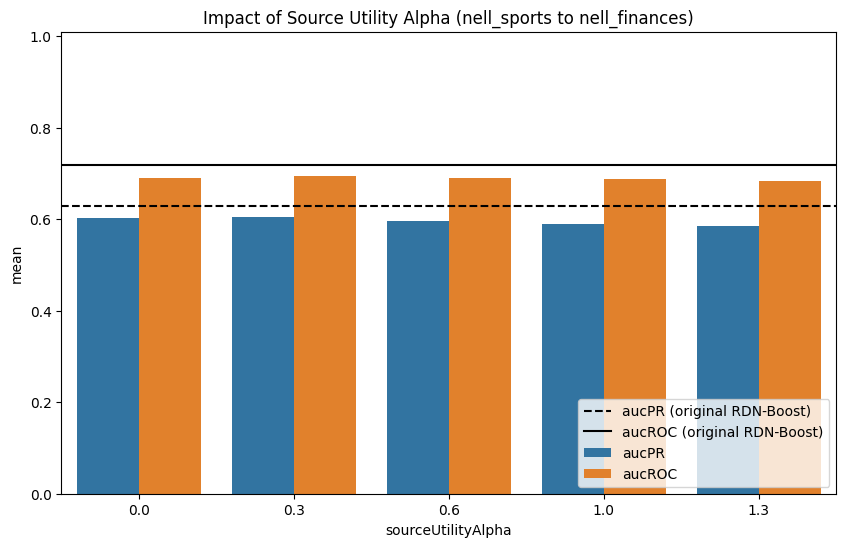

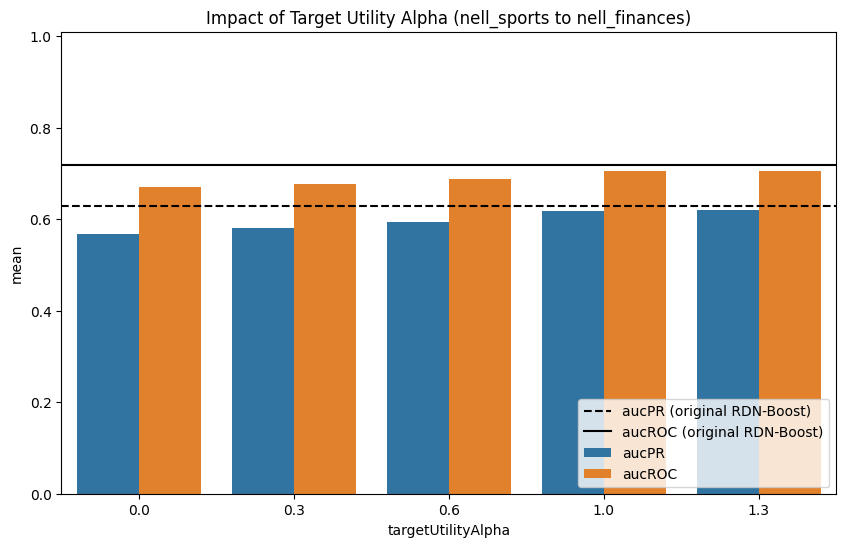

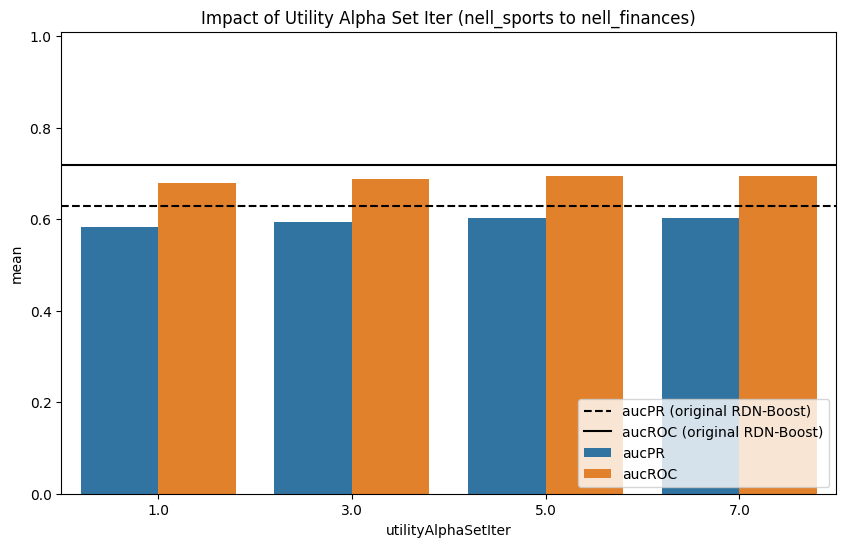

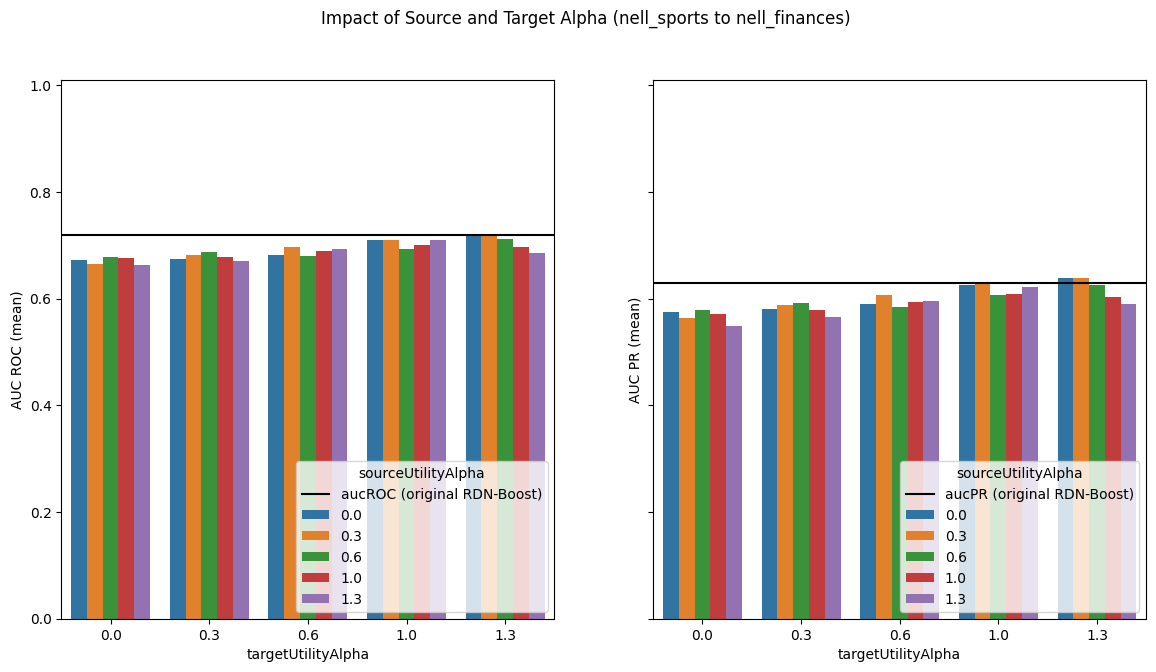

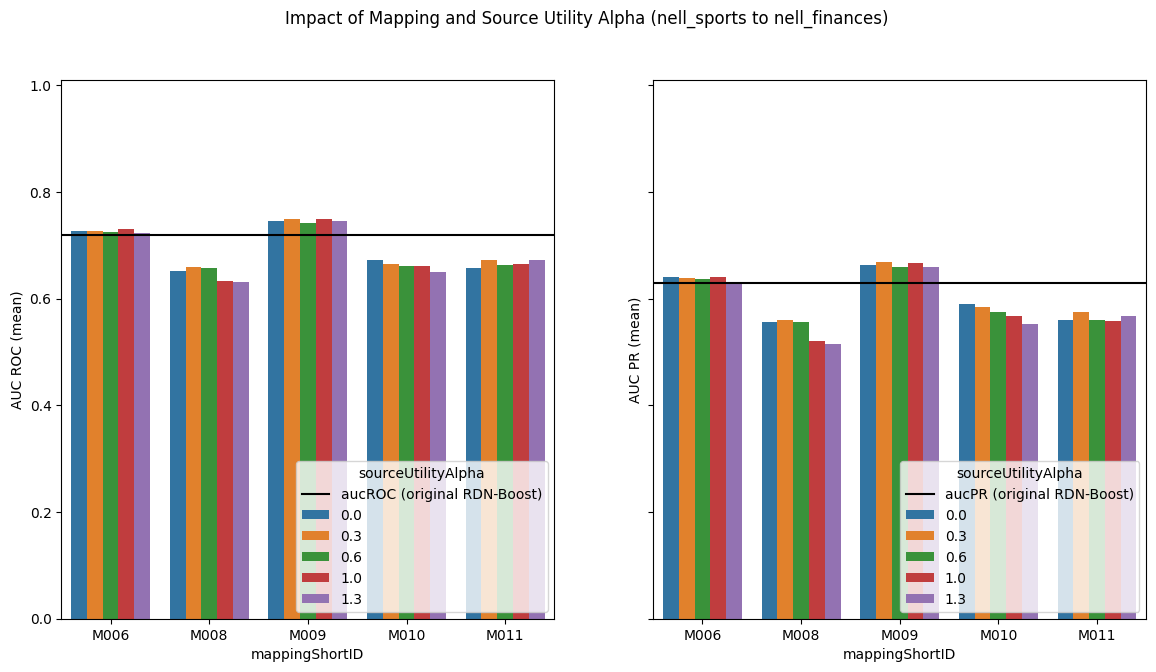

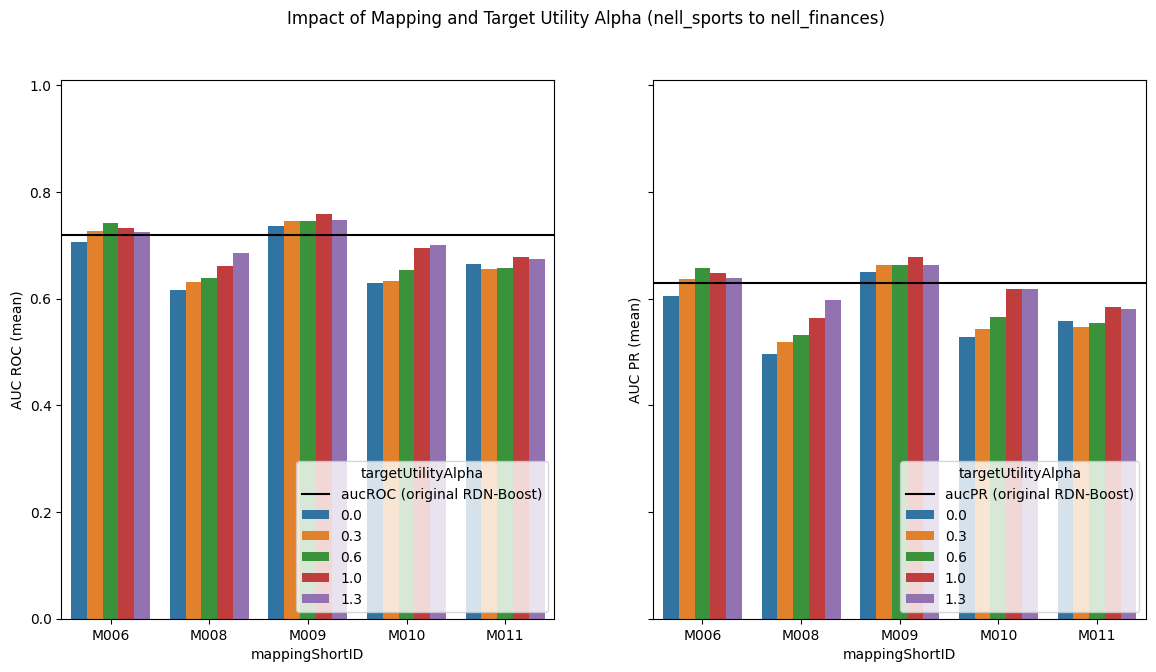

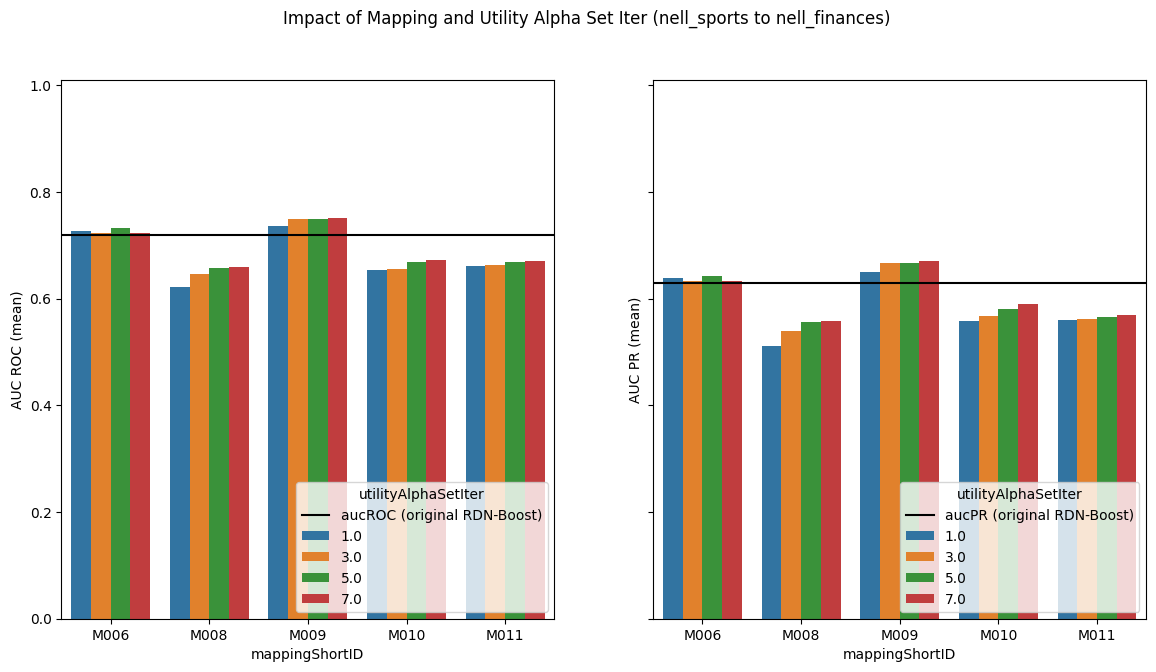

In [ ]:
analysisVariables = runAnalysis("nell_sports", "nell_finances")

# **NELL Finances To NELL Sports**

In [ ]:
transferLearningDF.iloc[0].id

'0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6fc661145e67a637b6b'

Learning from scratch using original RDN-Boost and data from nell_sports:
Experiment ID: 0726cac0b41d9aa866dbf57bd36b115ed1c50e11afedc0232f4809c47533219a
AUC-ROC: 0.9890479999999999 +- 0.006170375353250384
AUC-PR: 0.965925 +- 0.02659260282484589


Best AUC-ROC performance:
Experiment ID: 54ab7a686188f35592556347bf5251921a8ade4adb0ab22b7bcc078c9800b684
Source utility alpha: 1.3
Target utility alpha: 0.0
Utility alpha set iteration: 5.0
Relation mapping: {'companyceo': 'teamplayssport', 'recursion_companyceo': 'recursion_teamplayssport', 'countryhascompanyoffice': 'teamalsoknownas', 'companyeconomicsector': 'teamplaysagainstteam', 'economicsectorcompany': None, 'companyalsoknownas': None, 'cityhascompanyoffice': 'athleteplaysforteam', 'acquired': None, 'bankbankincountry': None, 'bankboughtbank': None, 'bankchiefexecutiveceo': None}
Term type mapping: {'company': 'sportsteam', 'person': 'sport', 'country': 'sportsteam', 'sector': 'sportsteam', 'city': 'athlete'}
AUC-ROC: 0.99650166666666

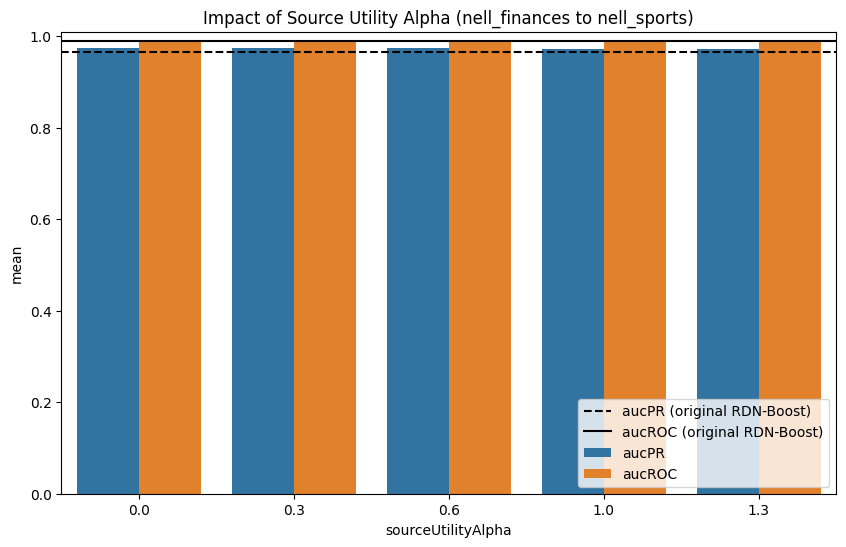

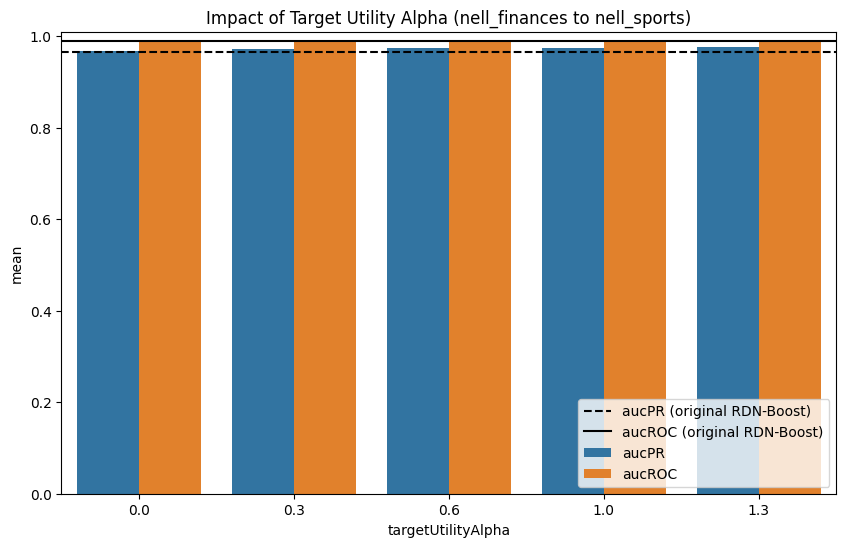

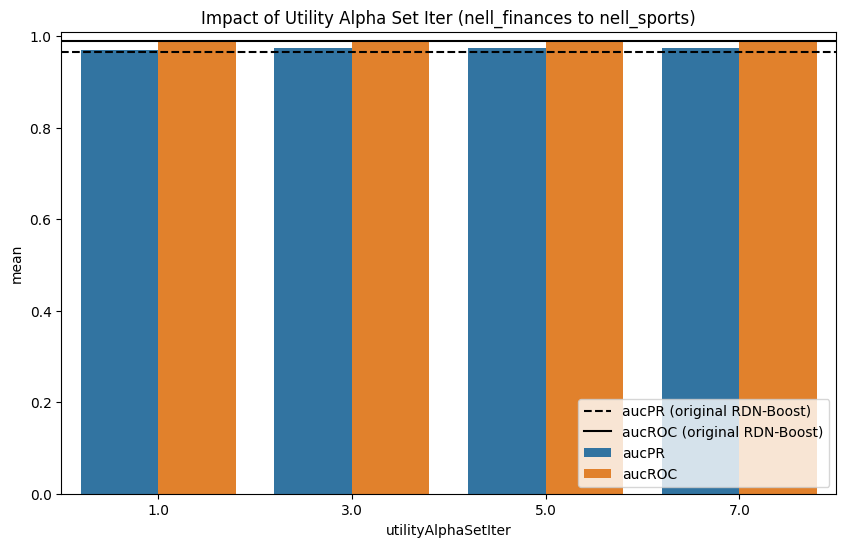

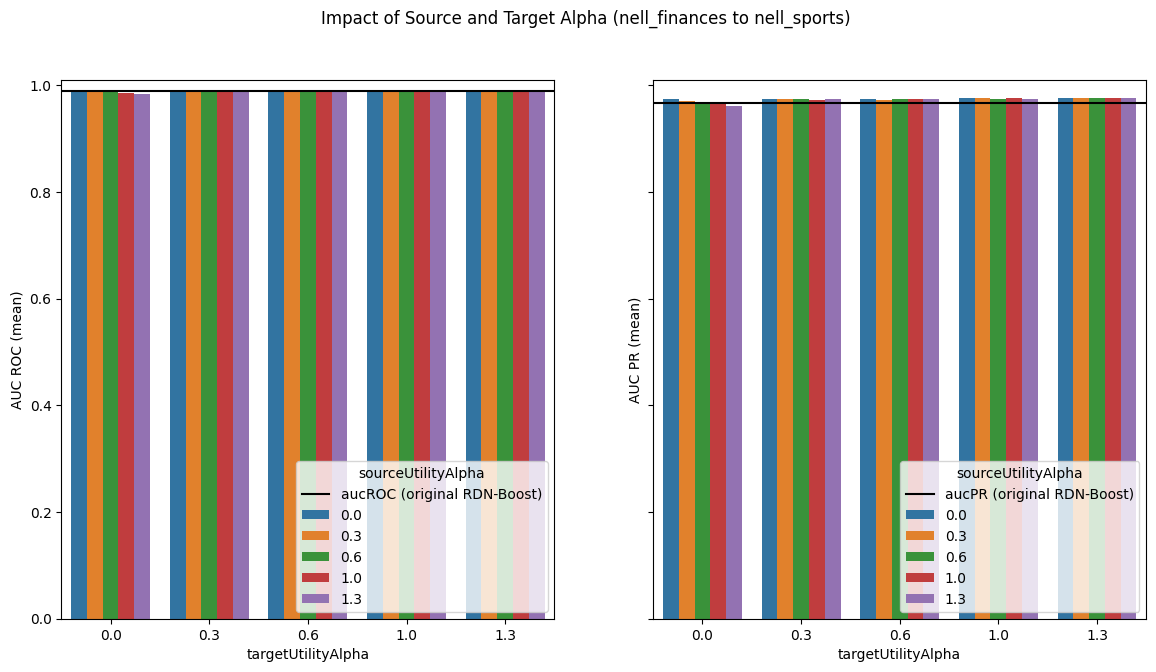

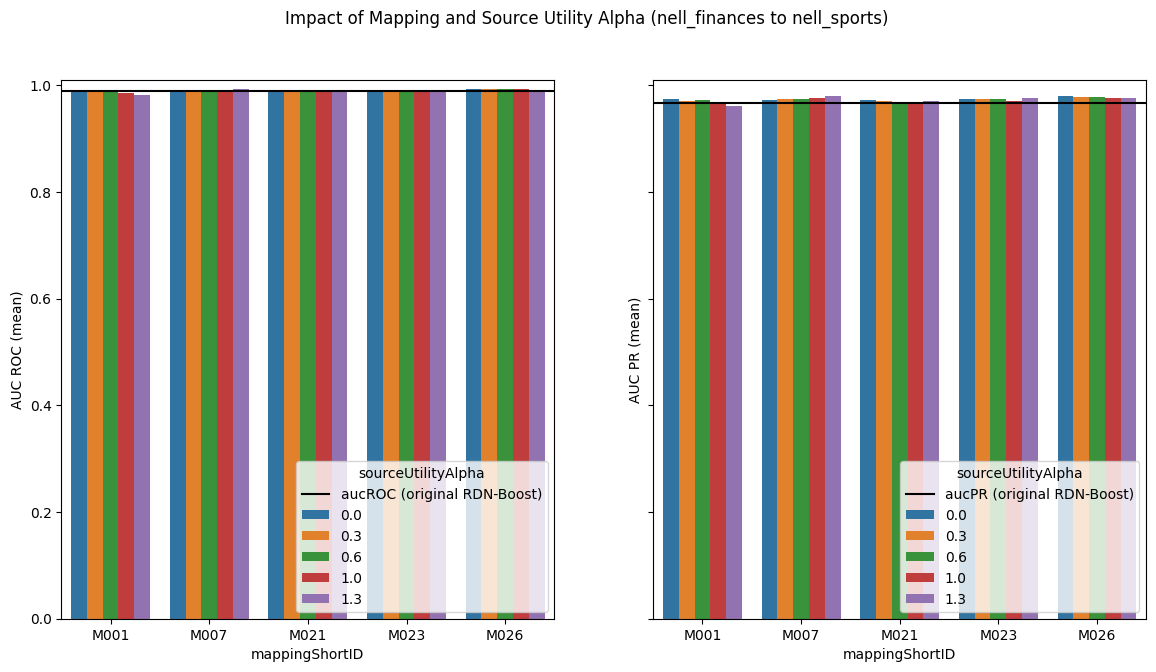

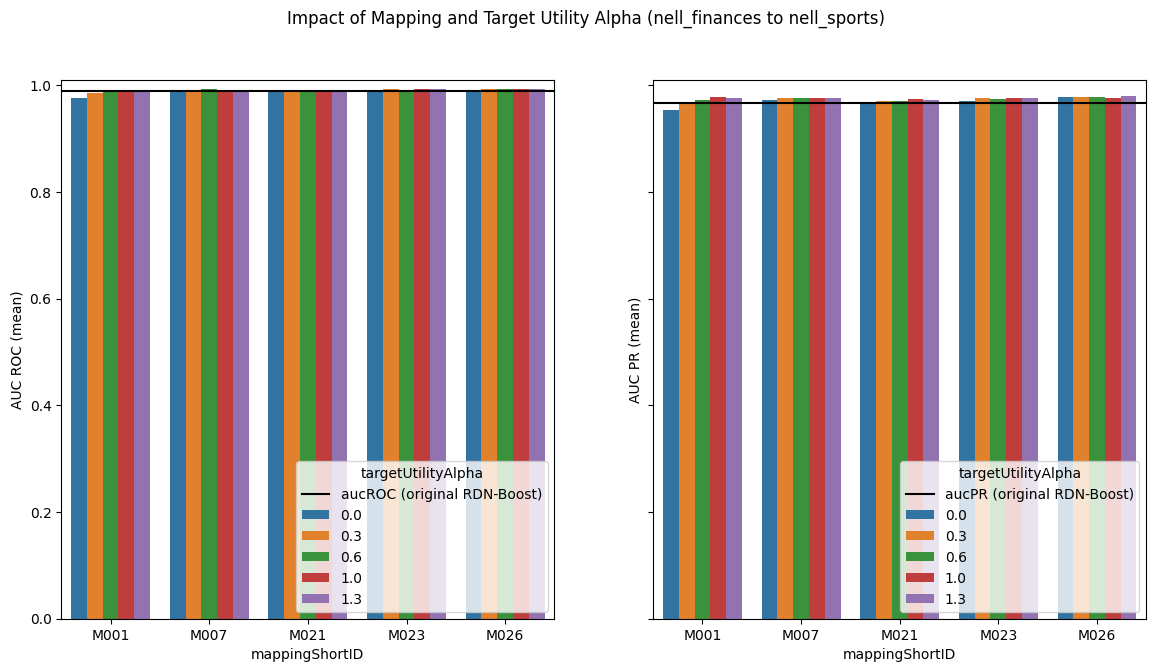

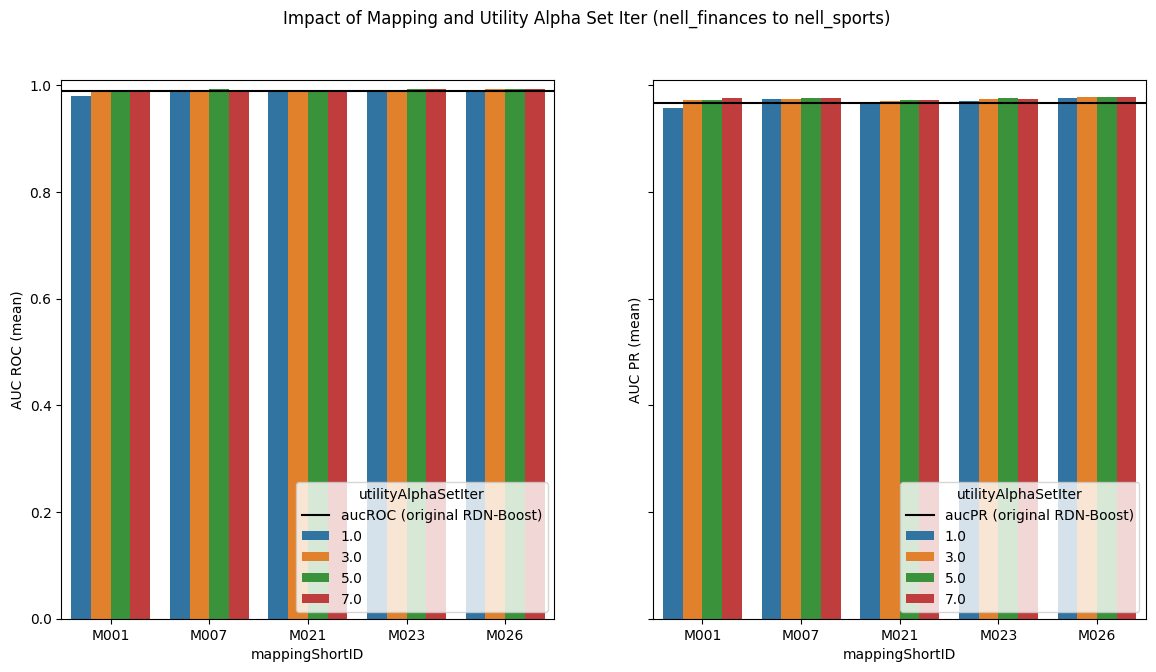

In [ ]:
analysisVariables = runAnalysis("nell_finances", "nell_sports")

# **IGNORE**

#### **Plots**

##### **Impact of Utility Alphas**

In [ ]:
# Plot hyperparameters
selectedAUC = "ROC" # "ROC" for AUC-ROC and "PR" for AUC-PR
selectedMappingIndex = 2 # It should be between 1 and 5 (we run experiments for five different mappings)
selectedMappingShortID = imdbToCoraTransferLearningDF.mappingShortID.unique()[selectedMappingIndex]

In [ ]:
plotDF = pd.merge(
    imdbToCoraTransferLearningDF[imdbToCoraTransferLearningDF.mappingShortID == selectedMappingShortID], 
    transferLearningMetricsDF, 
    left_on = "id", 
    right_on = "experimentID",
    how = "left"
).sort_values([
    "mappingShortID", "sourceUtilityAlpha", "utilityAlphaSetIter"
])

Text(0.5, 0, 'Source Utility Alpha')

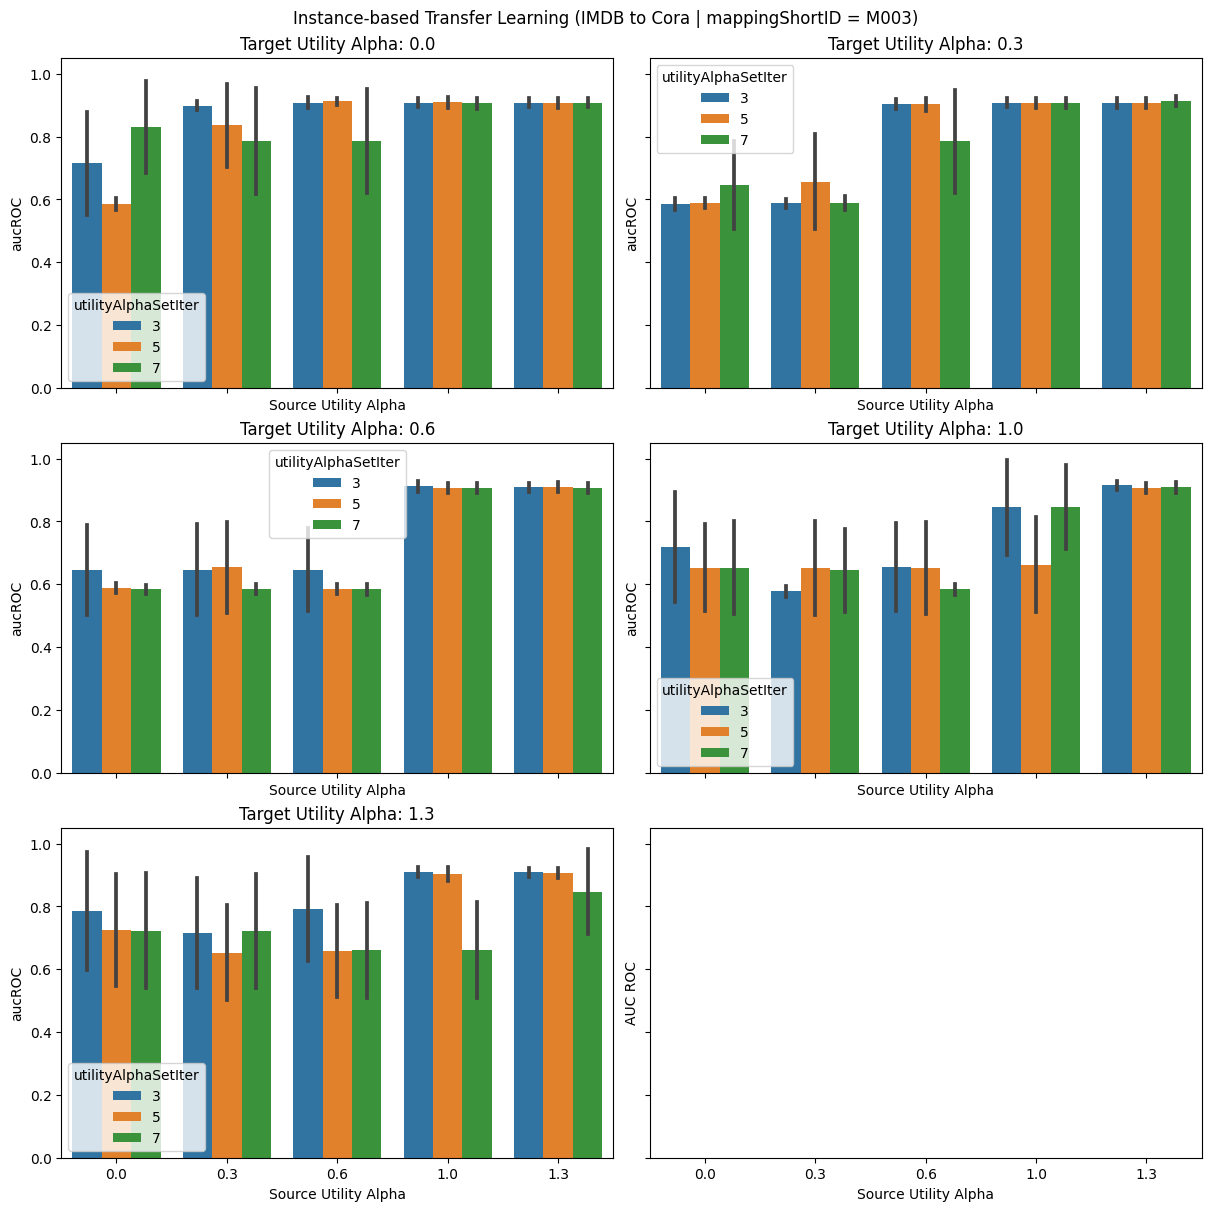

In [ ]:
targetUtilities = plotDF.targetUtilityAlpha.sort_values().unique()
totalTargetUtilities = len(targetUtilities)
nCols = 2
nRows = int(np.ceil(totalTargetUtilities/nCols))
aucROC_fig, aucROC_axes = plt.subplots(
    nRows, 
    nCols, 
    figsize = (12,12), 
    sharex = True, 
    sharey = True, 
    constrained_layout = True
)
for row in range(nRows):
    for col in range(nCols):
        subplotIdx = row*nCols + col
        if subplotIdx >= totalTargetUtilities:
            break

        targetUtility = targetUtilities[subplotIdx]
        subplotDF = plotDF[plotDF.targetUtilityAlpha == targetUtility]
        aucROC_fig = sns.barplot(
            data = subplotDF, 
            x = "sourceUtilityAlpha", 
            y = f"auc{selectedAUC}", 
            hue = "utilityAlphaSetIter",
            errorbar = "sd",
            ax = aucROC_axes[row, col]
        )
        aucROC_axes[row, col].set_title(f"Target Utility Alpha: {targetUtility}")
        aucROC_axes[row, col].set_xlabel("Source Utility Alpha")
plt.suptitle(f"Instance-based Transfer Learning (IMDB to Cora | mappingShortID = {selectedMappingShortID})")
plt.ylim((0,1.05))
plt.ylabel(f"AUC {selectedAUC}")
plt.xlabel("Source Utility Alpha")

##### **All Experiments**

In [ ]:
# Plot Hyperparameters
selectedAUC = "ROC" # "ROC" for AUC-ROC and "PR" for AUC-PR
selectedUtilityAlphaSetIter = 3 # It can be either 1, 3, 5, or 7 (these are the values we used in the experiments)

In [ ]:
plotDF = pd.merge(
    imdbToCoraTransferLearningDF[imdbToCoraTransferLearningDF.utilityAlphaSetIter == selectedUtilityAlphaSetIter], 
    transferLearningMetricsDF, 
    left_on = "id", 
    right_on = "experimentID",
    how = "left"
).sort_values([
    "mappingShortID", "sourceUtilityAlpha", "targetUtilityAlpha"
])

Text(0.5, 0, 'Mapping')

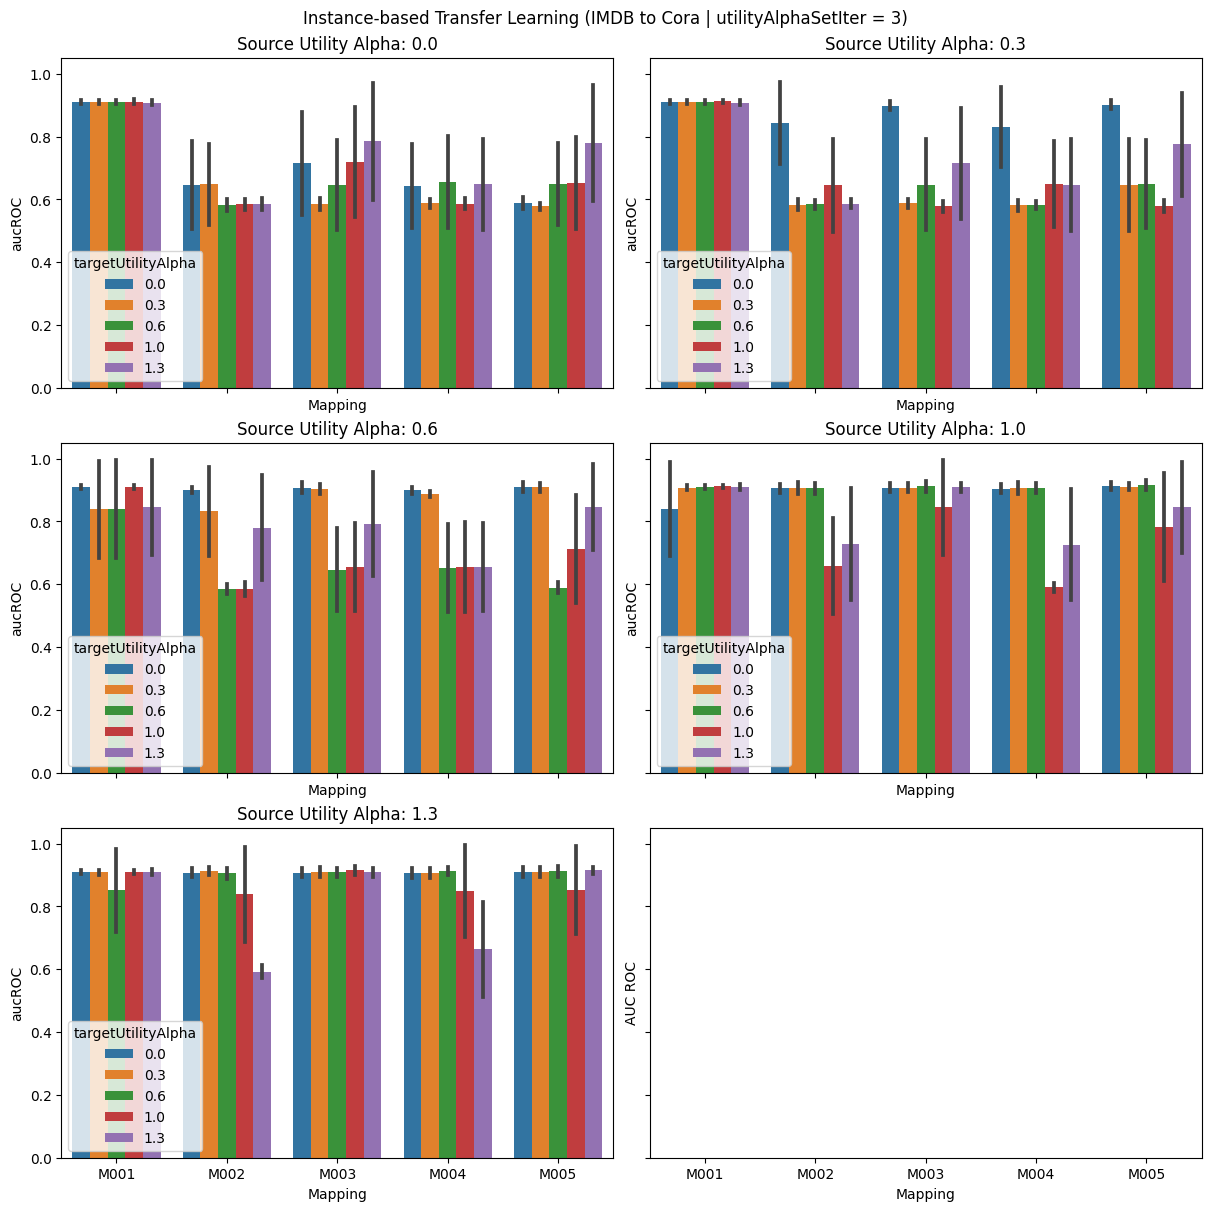

In [ ]:
sourceUtilities = plotDF.sourceUtilityAlpha.sort_values().unique()
totalSourceUtilities = len(sourceUtilities)
nCols = 2
nRows = int(np.ceil(totalSourceUtilities/nCols))
aucROC_fig, aucROC_axes = plt.subplots(
    nRows, 
    nCols, 
    figsize = (12,12), 
    sharex = True, 
    sharey = True, 
    constrained_layout = True
)
for row in range(nRows):
    for col in range(nCols):
        subplotIdx = row*nCols + col
        if subplotIdx >= totalSourceUtilities:
            break

        sourceUtility = sourceUtilities[subplotIdx]
        subplotDF = plotDF[plotDF.sourceUtilityAlpha == sourceUtility]
        aucROC_fig = sns.barplot(
            data = subplotDF, 
            x = "mappingShortID", 
            y = f"auc{selectedAUC}", 
            hue = "targetUtilityAlpha",
            errorbar = "sd",
            ax = aucROC_axes[row, col]
        )
        aucROC_axes[row, col].set_title(f"Source Utility Alpha: {sourceUtility}")
        aucROC_axes[row, col].set_xlabel("Mapping")
plt.suptitle(f"Instance-based Transfer Learning (IMDB to Cora | utilityAlphaSetIter = {selectedUtilityAlphaSetIter})")
plt.ylim((0,1.05))
plt.ylabel(f"AUC {selectedAUC}")
plt.xlabel("Mapping")

Text(0.5, 0, 'Mapping')

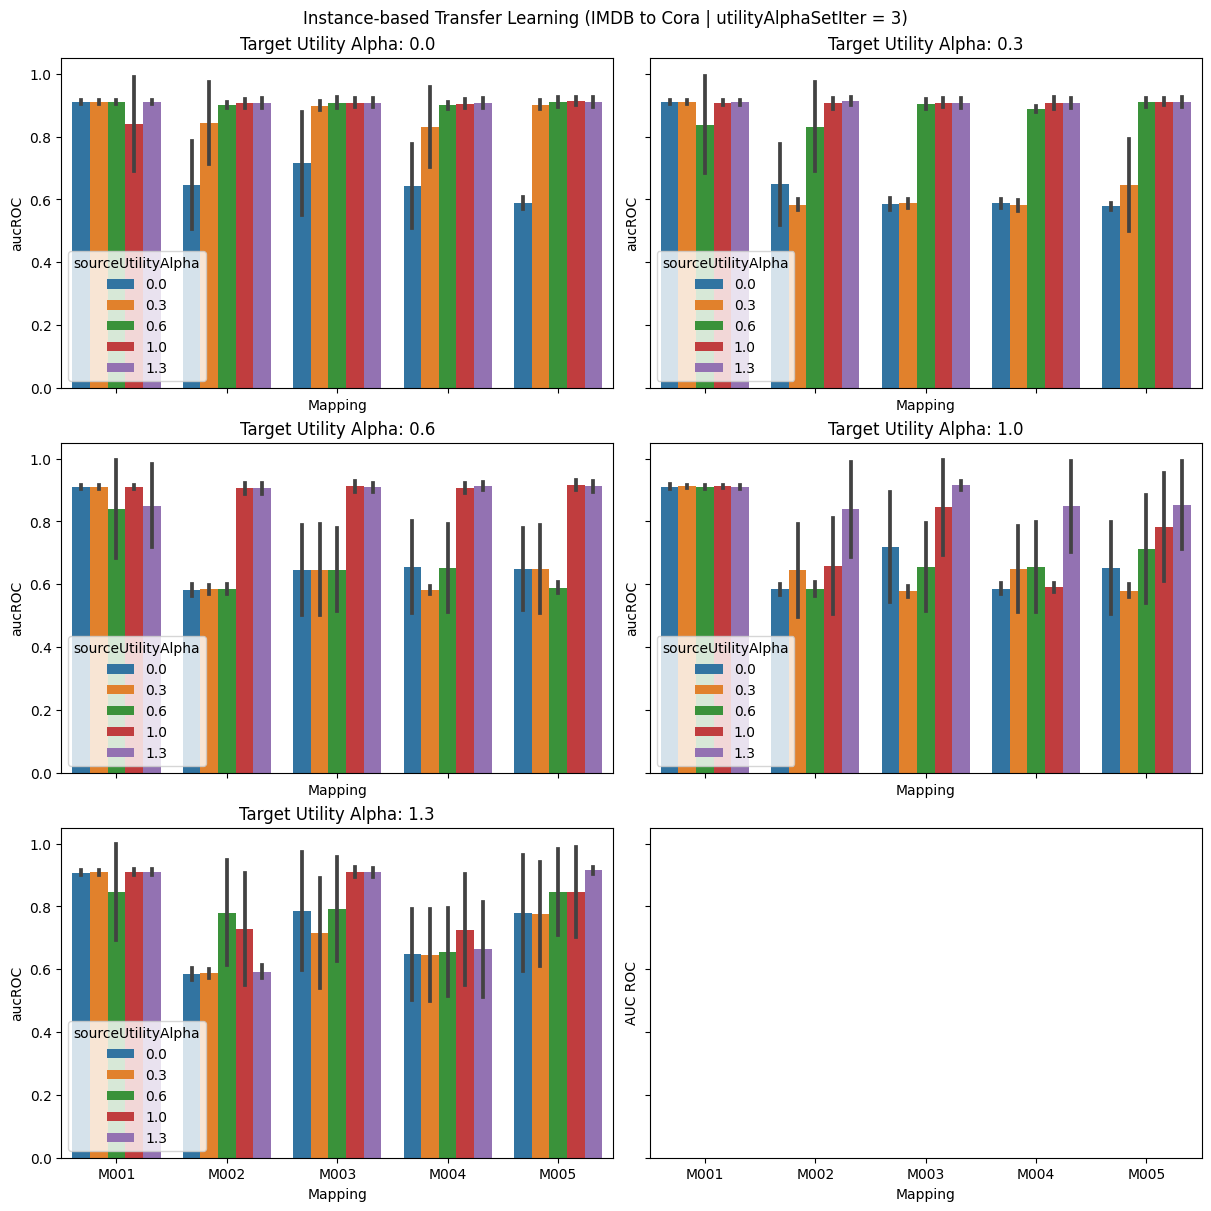

In [ ]:
targetUtilities = plotDF.targetUtilityAlpha.sort_values().unique()
totalTargetUtilities = len(targetUtilities)
nCols = 2
nRows = int(np.ceil(totalTargetUtilities/nCols))
aucROC_fig, aucROC_axes = plt.subplots(
    nRows, 
    nCols, 
    figsize = (12,12), 
    sharex = True, 
    sharey = True, 
    constrained_layout = True
)
for row in range(nRows):
    for col in range(nCols):
        subplotIdx = row*nCols + col
        if subplotIdx >= totalTargetUtilities:
            break

        targetUtility = targetUtilities[subplotIdx]
        subplotDF = plotDF[plotDF.targetUtilityAlpha == targetUtility]
        aucROC_fig = sns.barplot(
            data = subplotDF, 
            x = "mappingShortID", 
            y = f"auc{selectedAUC}", 
            hue = "sourceUtilityAlpha",
            errorbar = "sd",
            ax = aucROC_axes[row, col]
        )
        aucROC_axes[row, col].set_title(f"Target Utility Alpha: {targetUtility}")
        aucROC_axes[row, col].set_xlabel("Mapping")
plt.suptitle(f"Instance-based Transfer Learning (IMDB to Cora | utilityAlphaSetIter = {selectedUtilityAlphaSetIter})")
plt.ylim((0,1.05))
plt.ylabel(f"AUC {selectedAUC}")
plt.xlabel("Mapping")